<a href="https://colab.research.google.com/github/agroimpacts/adleo/blob/devel/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Semantic Segmentation

**<font color='red'> 44/50 points on A 3</font>**

## Instructions

Work through the assignment 2 notebook, and use this notebook to provide your answers. Be aware that the code cell for `customDataset` in this template is with complete instruction.

To submit the assignment, you will need to use GitHub and the existing private repository you already created called `adleoxyz` (xyz is your initials)

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment3_xyz.ipynb, with xyz again replaced by your initials.
- There are 50 points in this assignment, with an additional 8 extra credit.

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
%%capture
!pip install rasterio

In [4]:
import numpy as np
import os
import pandas as pd
import numpy.ma as ma
import rasterio
import cv2
import random
import math
import numbers
from pathlib import Path
from scipy.ndimage import rotate
from scipy.ndimage import shift

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from IPython.core.debugger import set_trace

## Coding Assignment 1: Build your own U-Net


In this assignment, your main task is to develop a U-Net model using the schematic provided in Figure 6 in the Chapter on Semantic Segmentation:

- In all code cells below change "your_model_name" with the name you choose for your model. My recommendation: "unet" + "_" + "your initial".
- Develop your model in a way that you can initialize it as follows:


    ```
    model_name(n_classes, in_channels, filter_config, dropout_rate=0):
    ```

    n_classes = number of categories in the semantic segmentation task.
    in_channels = number of bands in your input image chips.
    filter config = A list with integer elements that shows the number of output feature maps in each conv layer.
    dropout_rate = probability to apply drop out.

- You have two choices to place the dropout layer. At the end of each "conv block" or after each "pooling" layer.

    **Hint:** Check `SegNet` code on how to structure your encoder and decoder.

(20 points)


**<font color='red'> 18/20 points on CA 1</font>**

In [1]:
# class your_model_name(nn.Module):
#     def __init__(self, n_classes, in_channels,
#                  filter_config=(64, 128, 256, 512, 1024), dropout_rate=0):
#         """
#         Pytorch implementation of UNet with VGG16 backbone.

#         Args:
#             n_classes (int) : Number of categories in the semantic segmentation
#                 task.
#             in_channels (int) : Number of bands in your input image chips.
#             filter config : A list with integer elements that shows the number
#                 of output feature maps in each conv layer.
#             dropout_rate (float) : probability to apply drop out.

#         Returns:
#             Initialized pytorch.model object.
#         """
#         super(your_model_name, self).__init__()

#         # Initialize your layers for both encoder and decoder here.

#     def forward(self, inputs):

#         # call your layers in the order you want here.

#         return output_logits

class UNet_AN(nn.Module):
    def __init__(self, n_classes, in_channels, filter_config=(64, 128, 256, 512, 1024), dropout_rate=0):
        """
        Pytorch implementation of UNet with VGG16 backbone.

        Args:
            n_classes (int): Number of categories in the semantic segmentation task.
            in_channels (int): Number of bands in your input image chips.
            filter_config (list): A list with integer elements that shows the number
                                  of output feature maps in each conv layer.
            dropout_rate (float): Probability to apply dropout.

        Returns:
            Initialized pytorch model object.
        """
        super(UNet_AN, self).__init__()

        # Encoder path (downsampling)
        self.enc1 = self.conv_block(in_channels, filter_config[0])
        self.enc2 = self.conv_block(filter_config[0], filter_config[1])
        self.enc3 = self.conv_block(filter_config[1], filter_config[2])
        self.enc4 = self.conv_block(filter_config[2], filter_config[3])

        # Bottleneck
        self.bottleneck = self.conv_block(filter_config[3], filter_config[4])

        # Decoder path (upsampling)
        self.up4 = self.upconv_block(filter_config[4], filter_config[3])
        self.dec4 = self.conv_block(filter_config[4], filter_config[3])
        self.up3 = self.upconv_block(filter_config[3], filter_config[2])
        self.dec3 = self.conv_block(filter_config[3], filter_config[2])
        self.up2 = self.upconv_block(filter_config[2], filter_config[1])
        self.dec2 = self.conv_block(filter_config[2], filter_config[1])
        self.up1 = self.upconv_block(filter_config[1], filter_config[0])
        self.dec1 = self.conv_block(filter_config[1], filter_config[0])

        # Final output layer (maps to n_classes)
        self.final = nn.Conv2d(filter_config[0], n_classes, kernel_size=1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate > 0 else nn.Identity()

    def conv_block(self, in_channels, out_channels):
        """Helper function to create a block with two Conv2D layers and ReLU activations."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Helper function to define an upsampling layer using transposed convolution."""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, inputs):
        """
        Forward pass of U-Net.

        Args:
            inputs (Tensor): Input tensor with shape (batch_size, channels, height, width).

        Returns:
            Tensor: Output logits with shape (batch_size, n_classes, height, width).
        """
        # Encoder
        e1 = self.enc1(inputs)
        e2 = self.enc2(nn.MaxPool2d(kernel_size=2)(e1))
        e3 = self.enc3(nn.MaxPool2d(kernel_size=2)(e2))
        e4 = self.enc4(nn.MaxPool2d(kernel_size=2)(e3))

        # Bottleneck
        b = self.bottleneck(nn.MaxPool2d(kernel_size=2)(e4))

        # Decoder
        d4 = self.dec4(torch.cat((self.up4(b), e4), dim=1))
        d3 = self.dec3(torch.cat((self.up3(d4), e3), dim=1))
        d2 = self.dec2(torch.cat((self.up2(d3), e2), dim=1))
        d1 = self.dec1(torch.cat((self.up1(d2), e1), dim=1))

        # Apply dropout and final layer
        output_logits = self.dropout(self.final(d1))

        return output_logits


**TA Comment**

- Your implementation of Encoder and Decoder is wrong, look at the unet figure in the class readings.(semseg-2 fig 6)
- Bottleneck should be a collection of 1 by 1 convolutions
- Your unet works and doesn't retun tensor mismatch error, but still needs modification.
PLease check below implementation:
```
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate =0.5):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        return x

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class TripleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate =0.5):
        super(TripleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        return x


class unet_ra(nn.Module):
    def __init__(self, n_classes, in_channels,
                 filter_config=(64, 128, 256, 512, 1024, 1048), dropout_rate=0.5):
        """
        Pytorch implementation of UNet with VGG16 backbone.

        Args:
            n_classes (int) : Number of categories in the semantic segmentation
                task.
            in_channels (int) : Number of bands in your input image chips.
            filter config : A list with integer elements that shows the number
                of output feature maps in each conv layer.
            dropout_rate (float) : probability to apply drop out.

        Returns:
            Initialized pytorch.model object.
        """
        super(unet_ra, self).__init__()
        #encoder
        self.conv_block_enc_1 = DoubleConv(in_channels, filter_config[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block_enc_2 = DoubleConv(filter_config[0], filter_config[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block_enc_3 = DoubleConv(filter_config[1], filter_config[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block_enc_4 = TripleConv(filter_config[2], filter_config[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block_enc_5 = TripleConv(filter_config[3], filter_config[4])
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        #center
        self.center_1 = Bottleneck(filter_config[4], filter_config[5])

        #decoder
        self.up1 = nn.ConvTranspose2d(filter_config[5], filter_config[5], kernel_size=2, stride=2)
        self.conv_block_dec_1 = TripleConv(filter_config[5], filter_config[4])

        self.up2 = nn.ConvTranspose2d(filter_config[4], filter_config[3], kernel_size=2, stride=2)
        self.conv_block_dec_2 = TripleConv(filter_config[3], filter_config[3])

        self.up3 = nn.ConvTranspose2d(filter_config[3], filter_config[2], kernel_size=2, stride=2)
        self.conv_block_dec_3 = DoubleConv(filter_config[2], filter_config[2])

        self.up4 = nn.ConvTranspose2d(filter_config[2], filter_config[1], kernel_size=2, stride=2)
        self.conv_block_dec_4 = DoubleConv(filter_config[1], filter_config[1])

        self.up5 = nn.ConvTranspose2d(filter_config[1], filter_config[0], kernel_size=2, stride=2)
        self.conv_block_dec_5 = DoubleConv(filter_config[0], filter_config[0])

        self.out = nn.Conv2d(filter_config[0], n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

            #encoder
            enc1 = self.conv_block_enc_1(x)
            print(f"Shape of enc1: {enc1.shape}")
            pool1 = self.pool1(enc1)

            enc2 = self.conv_block_enc_2(pool1)           
            pool2 = self.pool2(enc2)

            enc3 = self.conv_block_enc_3(pool2)
            pool3 = self.pool3(enc3)

            enc4 = self.conv_block_enc_4(pool3)
            pool4 = self.pool4(enc4)
            
            enc5 = self.conv_block_enc_5(pool4)          
            pool5 = self.pool5(enc5)


            center = self.center_1(pool5)

            #decoder
            up1 = self.up1(center)
            print(f"Shape of up1: {up1.shape}")
            dec1 = self.conv_block_dec_1(up1)
            cat1 = torch.cat((enc5, dec1), dim=1)


            up2 = self.up2(dec1)
            dec2 = self.conv_block_dec_2(up2)
            cat2 = torch.cat((enc4, dec2), dim=1)


            up3 = self.up3(dec2)           
            dec3 = self.conv_block_dec_3(up3)                      
            cat3 = torch.cat((enc3, dec3), dim=1)


            up4 = self.up4(dec3)
            dec4 = self.conv_block_dec_4(up4)
            cat4 = torch.cat((enc2, dec4), dim=1)


            up5 = self.up5(dec4)
            dec5 = self.conv_block_dec_5(up5)
            cat5 = torch.cat((enc1, dec5), dim=1)


            out = self.out(dec5)
            return out
```            

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the UNet_AN class here (paste your class definition)

def test_unet_structure():
    # Initialize the model
    n_classes = 3
    in_channels = 1
    input_size = (256, 256)  # H x W
    model = UNet_AN(n_classes=n_classes, in_channels=in_channels)

    # Create dummy input tensor
    input_tensor = torch.randn(1, in_channels, *input_size)  # Batch size = 1
    print(f"Input tensor shape: {input_tensor.shape}")

    # Perform a forward pass and print intermediate tensor sizes
    try:
        # Encoder
        e1 = model.enc1(input_tensor)
        print(f"Encoder 1 output shape: {e1.shape}")
        e2 = model.enc2(F.max_pool2d(e1, kernel_size=2))
        print(f"Encoder 2 output shape: {e2.shape}")
        e3 = model.enc3(F.max_pool2d(e2, kernel_size=2))
        print(f"Encoder 3 output shape: {e3.shape}")
        e4 = model.enc4(F.max_pool2d(e3, kernel_size=2))
        print(f"Encoder 4 output shape: {e4.shape}")

        # Bottleneck
        b = model.bottleneck(F.max_pool2d(e4, kernel_size=2))
        print(f"Bottleneck output shape: {b.shape}")

        # Decoder
        d4 = model.dec4(torch.cat((model.up4(b), e4), dim=1))
        print(f"Decoder 4 output shape: {d4.shape}")
        d3 = model.dec3(torch.cat((model.up3(d4), e3), dim=1))
        print(f"Decoder 3 output shape: {d3.shape}")
        d2 = model.dec2(torch.cat((model.up2(d3), e2), dim=1))
        print(f"Decoder 2 output shape: {d2.shape}")
        d1 = model.dec1(torch.cat((model.up1(d2), e1), dim=1))
        print(f"Decoder 1 output shape: {d1.shape}")

        # Final output
        output_tensor = model.dropout(model.final(d1))
        print(f"Output tensor shape: {output_tensor.shape}")

        # Check input-output size consistency
        assert output_tensor.shape[2:] == input_size, "Mismatch in input and output spatial dimensions!"
        print("Model structure is valid and output size matches input size.")

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the test
if __name__ == "__main__":
    test_unet_structure()


Input tensor shape: torch.Size([1, 1, 256, 256])
Encoder 1 output shape: torch.Size([1, 64, 256, 256])
Encoder 2 output shape: torch.Size([1, 128, 128, 128])
Encoder 3 output shape: torch.Size([1, 256, 64, 64])
Encoder 4 output shape: torch.Size([1, 512, 32, 32])
Bottleneck output shape: torch.Size([1, 1024, 16, 16])
Decoder 4 output shape: torch.Size([1, 512, 32, 32])
Decoder 3 output shape: torch.Size([1, 256, 64, 64])
Decoder 2 output shape: torch.Size([1, 128, 128, 128])
Decoder 1 output shape: torch.Size([1, 64, 256, 256])
Output tensor shape: torch.Size([1, 3, 256, 256])
Model structure is valid and output size matches input size.


### Show your work

To test if you got it right lets initialize our model and print it.

In [ ]:
n_classes = 2
in_channels = 6
filter_config = 64, 128, 256, 512, 1024
dropout_rate = 0.15

In [ ]:
model = UNet_AN(n_classes, in_channels, filter_config, dropout_rate)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 31,033,538 trainable parameters


In [ ]:
print(model)

UNet_AN(
  (enc1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024

## Coding assignment 2: Working with a custom dataset in `PyTorch`

In the semantic segmentation Practical 3, Part 2, you are given the code and explanation for common pre-processing techniques and the components of `torch.utils.data.Dataset`, which you need to overwrite to pre-process and load your own dataset for the purpose of training, fine-tuning, validation and prediction.

Please do the following:

- You are provided with the code for input normalization and some common image augmentation.

- You are also given some input data located in the class shared folder on gdrive under relative path `./GEOG315/assignment3_data/tile_xxx_xx`:

    The dataset consists of preprocessed Landsat-8 tiles of Indonesia. Landsat tiles are clipped to the coastal region. The imagery is pan-sharpened to 15 meters pixel size and atmospherically corrected to the ground reflectance. Note that only the first 3 bands are provided. Each tile is also accompanied by an annotation layer in the form of a binary mask that shows pond aquaculture vs. non-pond (e.g. label folder). The labels are based on the work done in [Clark Labs](https://clarklabs.org/aquaculture/). We also include the study area mask that has been used to clip the original Landsat tiles.

- For the purpose of this assignment we focus on the active loading strategy. Your job is to modify the `ActiveLoadingDataset()` class to do the following:
    - Read your input image, label and mask.
    - Do image normalization (either min/max or z-score),
    - Chip the imagery and labels into tiles of 256x256. Use 25% for "overlap" and 15% for "positive_class_threshold" arguments in the chipping process.
    - Apply on-the-fly augmentation on your image, label, or both depending on your choice of augmentation. For this assignment you only need to add two augmentation of your choice.
    - Note that using flip is a bit tricky as it has two options and you want the code to be flexible to choose either horizontal (hflip) or vertical (vflip)randomly chosen in each epoch.
- An incomplete `ActiveLoadingDataset()` class is provided for you in the template provided in Practical 3. You must add your code in the specified parts
- The completed code, upon calling, must be able to successfully create your train or validation dataset.

(30 points)


**<font color='red'> 26/30 points on CA 2</font>**

### Static code

In [5]:
#@title Input normalization
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) -- Absolute path to the image patch.
    dtype (numpy datatype) -- data type of the normalized image default is "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)
    # normalized_img = normalized_img.astype(dtype)

    # Return the normalized image data
    return normalized_img

#### Image augmentation
Two functions for augmentation are included in the static code here. You can choose from these, or include others from the main assignment instead (e.g. translation, blur, gamma). If you do choose to add others, please add the functions into the chunks where indicated below in Coding Task section below.

In [6]:
#@title Rotation transformation (`cv2`)

import cv2
import numpy as np
import random

def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle
            (in degrees) respectively. If number of elements are bigger than 2,
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )

    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2],
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2],
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

In [7]:
#@title Image flipping (`cv2`)
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)

        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)

    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)

        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)

    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")

    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

#### Chipping

In [8]:
#@title Get the center index for chipping
def patch_center_index(cropping_ref, patch_size, overlap, usage,
                       positive_class_threshold=None, verbose=True):
    r"""
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the
            proportion of positive class to the total areal of the chip. Used to
            decide if the chip should be considered as a positive chip in the
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of
        patches to extract from the input
    """

    assert usage in ["train", "val"]

    mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate index for the center of each patch considering the proportion of
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size,
                            j - half_size: j + half_size]
            label_ref = label[i - half_size: i + half_size,
                              j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "val") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without
    # considering the class proportions.
    if usage == "val":
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

#### Helper functions

Code for plotting images.  You will use these to demonstrate your work.

In [9]:
#@title Plot RGB composite or single band image

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image(image_array, cmap="grey", band_composite=None, stretch=None):
    r"""
    Plots a loaded image using matplotlib and rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        stretch (str) : A string specifying the contrast stretch to apply to the
            image (e.g. 'linear', 'sqrt', or 'log').
        cmap (str) : A string specifying the color map to use for the image
            (default:'gray').
        band_composite (tuple of int) : A tuple specifying the band indices to
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    if ((image_array.ndim == 3) and
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)

    image_size=[image_array.shape[0], image_array.shape[1]]

    # If a band composite is specified, create an RGB image
    if band_composite:
        # Get the individual bands
        red_band = image_array[:, :, band_composite[0] - 1]
        green_band = image_array[:, :, band_composite[1] - 1]
        blue_band = image_array[:, :, band_composite[2] - 1]

        # Stack the bands to create an RGB image
        rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

        # Apply the contrast stretch if specified
        if stretch:
            p_min, p_max = np.percentile(rgb_image, (2, 98))
            stretched = exposure.rescale_intensity(
                rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = rgb_image

        # Display the RGB image using matplotlib
        ax.imshow(stretched)

    # Otherwise, display the single-band image
    else:
        if stretch:
            p_min, p_max = np.percentile(image_array, (2, 98))
            stretched = exposure.rescale_intensity(
                image_array, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = image_array

        # Display the image using rasterio.plot.show
        rp.show(stretched, ax=ax, cmap=cmap)


    # Add a title and axis labels
    ax.set_title('Image')
    ax.set_xlabel(f'# Column: {image_size[0]}')
    ax.set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    plt.show()

In [10]:
#@title Plot RGB composite and label pair

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image_and_label(image_array, label_array, band_composite=None,
                         stretch=None):
    r"""
    Plots a loaded image and its corresponding label using matplotlib and
    rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        label_array (numpy.ndarray) : A numpy array containing label data.
        stretch (str) : A string specifying the contrast stretch to apply to the
            image (e.g. 'linear', 'sqrt', or 'log').
        band_composite (tuple of int) : A tuple specifying the band indices to
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    if ((image_array.ndim == 3) and
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)

    image_size=[image_array.shape[0], image_array.shape[1]]
    label_size=[label_array.shape[0], label_array.shape[1]]

    # If a band composite is specified, create an RGB image
    red_band = image_array[:, :, band_composite[0] - 1]
    green_band = image_array[:, :, band_composite[1] - 1]
    blue_band = image_array[:, :, band_composite[2] - 1]

    # Stack the bands to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    # Apply the contrast stretch if specified
    if stretch:
        p_min, p_max = np.percentile(rgb_image, (2, 98))
        stretched = exposure.rescale_intensity(
            rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
        )
    else:
        stretched = rgb_image

    # Display the RGB image using matplotlib
    axs[0].imshow(stretched)

    # Add a title and axis labels
    axs[0].set_title('Image')
    axs[0].set_xlabel(f'# Column: {image_size[0]}')
    axs[0].set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    axs[0].axis('off')

    # Plot label chip
    axs[1].imshow(label_array, cmap='viridis')
    axs[1].set_title('Label')
    axs[1].set_xlabel(f'# Column: {label_size[0]}')
    axs[1].set_ylabel(f'# Row: {label_size[1]}')

    # Show the plot
    axs[1].axis('off')
    plt.show()

In [11]:
#@title Plot random patches from the Pytorch customDataset object.

import numbers
import matplotlib.pyplot as plt

def show_random_patches(dataset, sample_num, rgb_bands=(4, 5, 3)):
    """
    Plots a user-defined number of image chips and the corresponding labels.
    Arguments:
    dataset (AquacultureData object) : Loaded custom dataset.
    sample_num (int) : Number of pairs of image chips and their corresponding
        labels to be plotted.
    rgb_bands (tuple of int) : List of the rgb bands for visualization indexed
        from zero.
    Note: The order of the input bands is as follows:
          bands = {0 : "Landsat band 2 (Blue)",
                   1 : "Landsat band 3 (Green)",
                   2 : "Landsat band 4 (Red)",
                   3 : "Landsat band 5 (NIR)",
                   4 : "Landsat band 6 (SWIR 1)",
                   5 : "Landsat band 7 (SWIR 2)"}
    """
    # Because train_dataset does dynamic augmentation, we first make a deep copy
    # of it before ploting.
    static_dataset = list(dataset)

    if ((isinstance(rgb_bands, tuple) or isinstance(rgb_bands, list)) and
            (len(rgb_bands) == 3) and
            (isinstance(rgb_bands[0], numbers.Number) and
             isinstance(rgb_bands[1], numbers.Number) and
             isinstance(rgb_bands[2], numbers.Number)) and
            ((sample_num is not None) and
             (1 <= sample_num <= len(static_dataset)))):
        r = rgb_bands[0]
        g = rgb_bands[1]
        b = rgb_bands[2]

        nrow = sample_num
    else:
        del static_dataset
        raise ValueError("'sample_num' or 'rgb_bands' are not properly defined")

    # Randomly select as many patches as the user defined for plotting.
    sample_index = []
    ncol = 2

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, nrow * 16 / 2),
                            squeeze=False)

    for index in range(sample_num):
        sample_index.append(random.randrange(len(static_dataset)))

    viewSize = static_dataset[sample_index[0]][1].shape

    for i in range(sample_num):
        b_r = static_dataset[sample_index[i]][0][r,:,:].cpu().view(1, *viewSize)
        b_g = static_dataset[sample_index[i]][0][g,:,:].cpu().view(1, *viewSize)
        b_b = static_dataset[sample_index[i]][0][b,:,:].cpu().view(1, *viewSize)

        if (b_r.max() - b_r.min()) > 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0).int()

        elif 0 <= (b_r.max() - b_r.min()) <= 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0)

        axs[i, 0].set_title('Image Patch #{}'.format(sample_index[i]))
        axs[i, 0].imshow(rgb)
        axs[i, 1].set_title('Label Patch #{}'.format(sample_index[i]))
        axs[i, 1].imshow(static_dataset[sample_index[i]][1])

    plt.show()
    del static_dataset

### Coding Tasks

Modify the code below here to complete the second coding assignment.

#### Load the dataset
Let's first make ourselves familiar with our dataset, using `rasterio`.

Note that we're not passing any arguments to `src.read()` since we want to read all bands of the image. If you want to read a specific band, you can pass the band number as an argument (e.g. `src.read(3)` to read the third band).

First we load the imagery. The image source is kept in a csv catalog that will provides the file name and path for the label image, the mask image, and the Landsat image. There are set of these for each training and validation. Let's have a look.

In [13]:
# Define the path to the catalog in Google Drive (shared with you).
# Modify it as needed to match your Drive structure.
# you may find it helpful to define a variable that contains the path root
# (src_dir)
src_dir = "/content/gdrive/MyDrive/sam/GEOG315/assignment3_data" #"/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data"
csv_name = "pond_scenes_train_val.csv"
catalog = pd.read_csv(os.path.join(src_dir, csv_name))
catalog

,country,region,wrs_path,wrs_row,year,usage,img_dir,label_dir,mask_dir
0,indonesia,indramayu,121,64,2014,train,clip_tile_121_64/bands/comp456_2014_clip_121_6...,clip_tile_121_64/label/ponds_2014_clip_121_64.rst,clip_tile_121_64/mask/mask_2014_clip_121_64.rst
1,indonesia,jakarta,122,64,2014,validate,clip_tile_122_64/bands/comp456_2014_clip_122_6...,clip_tile_122_64/label/ponds_2014_clip_122_64.rst,clip_tile_122_64/mask/mask_2014_clip_122_64.rst


Now let's use those directory paths in the csv to read in and display the imagery, label, and mask for the training path.

In [14]:
# Define the path to the image file in Google Drive
img_path = os.path.join(src_dir, catalog[catalog.usage=='train']['img_dir'][0])

# Open the image with rasterio
with rasterio.open(img_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    image_array = src.read()
    image_array = image_array.transpose(1,2,0)

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockxsize': 3975, 'blockysize': 1, 'tiled': False}


Let's get the labels

In [15]:
# Define the path to the label file in Google Drive
lbl_path = os.path.join(src_dir,
                        catalog[catalog.usage=='train']['label_dir'][0])

with rasterio.open(lbl_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    lbl_array = src.read(1)

{'driver': 'RST', 'dtype': 'float32', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockxsize': 3975, 'blockysize': 1, 'tiled': False}


Let's visualize the image and labels. Note that you can change the order of the 3 bands for different renderings.

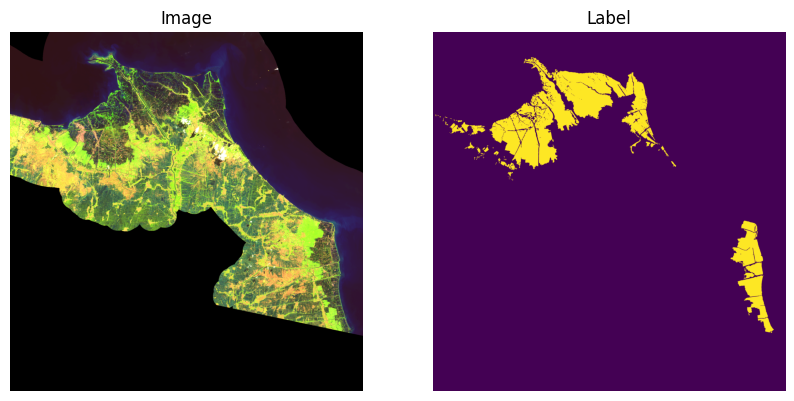

In [ ]:
band_composite=(2,1,0)
stretch = True

plot_image_and_label(image_array, lbl_array, band_composite, stretch)

Last, we will look at the mask image.

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockxsize': 3975, 'blockysize': 1, 'tiled': False}


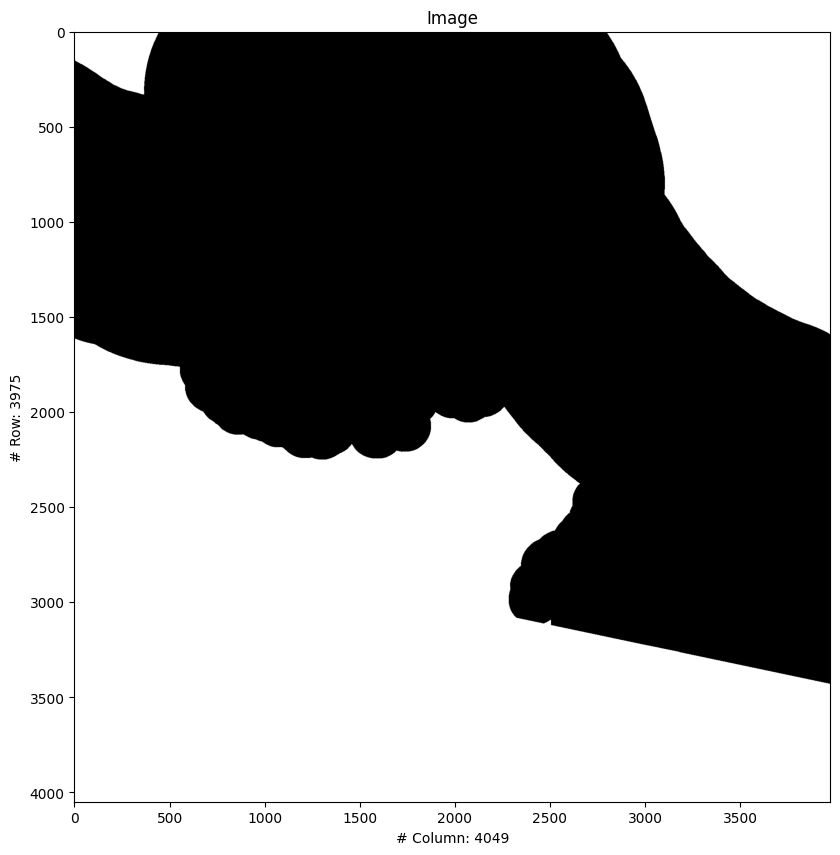

In [ ]:
msk_path = os.path.join(src_dir, catalog[catalog.usage=='train']['mask_dir'][0])

with rasterio.open(msk_path) as src:
    print(src.profile)
    msk_array = src.read(1)

plot_image(msk_array, "Greys")

So that's the imagery.  Now we will to move on to examining augmentations.

#### Test the image processing/augmentation functions

You will want to see--and demonstrate--how the augmentations work, and we will want to see them outside of the data loader that you will be making below.  So, let's run them first.  

#### Normalization

You will need to start by applying image normalization. Run your normalization code here.

You might want to write a function that simultaneously loads the image and applies the normalization at the same time. You might even want to make it so that the function can differentiate between images and labels. For the images, note that you might have to be careful to run the transpose after normalizing.  


##### Optional coding assignment 1

(3 extra points)

Modify the min-max input normalization (`min_max_normalize_image`) to clip the tail distributions based on a "clip_threshold" argument. For instance, trim of the 1st and 99th percentile values in each image.


To do this, modify the `min_max_normalize_image` function cell below, renaming it `min_max_normalize_image_wclip`. Run it instead of `min_max_normalize_image` when normalizing your image (we recommend applying a 1% clip to either tail), both here and in the custom loader.

In [ ]:
## Modify the normalization function here. Otherwise leave as is.
# def min_max_normalize_image_wclip(...):

def min_max_normalize_image_wclip(image, clip_threshold=1):
    """
    Applies min-max normalization with optional clipping to the input image.

    Parameters:
    - image: numpy array representing the input image.
    - clip_threshold: float, percentage of tails to clip (default is 1%).

    Returns:
    - Normalized image as a numpy array.
    """
    # Compute the clipping bounds based on percentiles
    lower, upper = np.percentile(image, [clip_threshold, 100 - clip_threshold])

    # Clip the values to the specified bounds
    clipped_image = np.clip(image, lower, upper)

    # Apply min-max normalization
    normalized_image = (clipped_image - lower) / (upper - lower)

    return normalized_image


  # Create a test array
test_array = np.array([
    [10, 20, 30],
    [40, 50, 60],
    [70, 80, 90]
], dtype=float)

# Apply your function with a clip_threshold
normalized_array = min_max_normalize_image_wclip(test_array, clip_threshold=10)

print("Original Array:")
print(test_array)
print("\nNormalized Array:")
print(normalized_array)



Original Array:
[[10. 20. 30.]
 [40. 50. 60.]
 [70. 80. 90.]]

Normalized Array:
[[0.      0.03125 0.1875 ]
 [0.34375 0.5     0.65625]
 [0.8125  0.96875 1.     ]]


##### Load image and apply normalization


**TA Comment**

np.percentile in your implementation is computeing the upper and lower over all elements, not per channel.

"np.percentile(image, clip_threshold, **axis=(0, 1)**, **keepdims=True**)"

you're using the upper and lower values to do the scaling which is wrong. you will need to calculate min and max still and do the normalization based on those.

Check this implementation:



```
def min_max_normalize_image_wclip(image, is_label=False, clip_threshold=1):
    """
    Applies Min-Max normalization with percentile clipping directly to an image array.
    Assumes input image shape is (H, W, C).

    Args:
        image (numpy array): Input image array.
        is_label (bool): Whether the array is a label (default: False).
        clip_threshold (float): Percentage for clipping the tails (default: 1, meaning 1st and 99th percentiles).

    Returns:
        np.array: Normalized image (if is_label is False) or raw label.
    """
    if not is_label:
        # Compute lower and upper percentiles along the spatial dimensions (axis 0 and 1)
        lower_bound = np.percentile(image, clip_threshold, axis=(0, 1), keepdims=True)
        upper_bound = np.percentile(image, 100 - clip_threshold, axis=(0, 1), keepdims=True)
        # Clip the tails
        image = np.clip(image, lower_bound, upper_bound)
        # Min-Max normalization
        min_values = np.nanmin(image, axis=(0, 1), keepdims=True)
        max_values = np.nanmax(image, axis=(0, 1), keepdims=True)
        image = (image - min_values) / (max_values - min_values + 1e-8)
    return image
```




In [ ]:
# Write your code for applying normalization here. Probably easiest to read in
# the image again, normalize, and then transpose

def load_and_normalize_image(img_path, clip_threshold=1):
    """
    Reads an image, applies normalization, and transposes it for further processing.

    Parameters:
    - img_path: str, path to the image file.
    - clip_threshold: float, percentage of tails to clip (default is 1%).

    Returns:
    - normalized_image: numpy array, normalized and transposed image.
    """
    try:
        # Open the image using rasterio
        with rasterio.open(img_path) as src:
            # Read all image bands as a float32 array
            image = src.read().astype(np.float32)

        # Normalize each band independently
        normalized_image = np.empty_like(image)
        for i in range(image.shape[0]):  # Iterate over bands
            normalized_image[i] = min_max_normalize_image_wclip(image[i], clip_threshold)

        # Transpose to (height, width, channels) format
        return normalized_image.transpose(1, 2, 0)

    except Exception as e:
        print(f"Error processing the image: {e}")
        return None

# Example usage
src_dir = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data"
csv_name = "pond_scenes_train_val.csv"
catalog = pd.read_csv(os.path.join(src_dir, csv_name))

# Define the path to the image file
img_path = os.path.join(src_dir, catalog[catalog.usage == 'train']['img_dir'].iloc[0])

# Apply normalization
normalized_image = load_and_normalize_image(img_path, clip_threshold=1)

if normalized_image is not None:
    print("Normalization and transposition successful!")
else:
    print("Failed to process the image.")

Normalization and transposition successful!


##### Plot the normalized image
Show your result here by running the plotting code

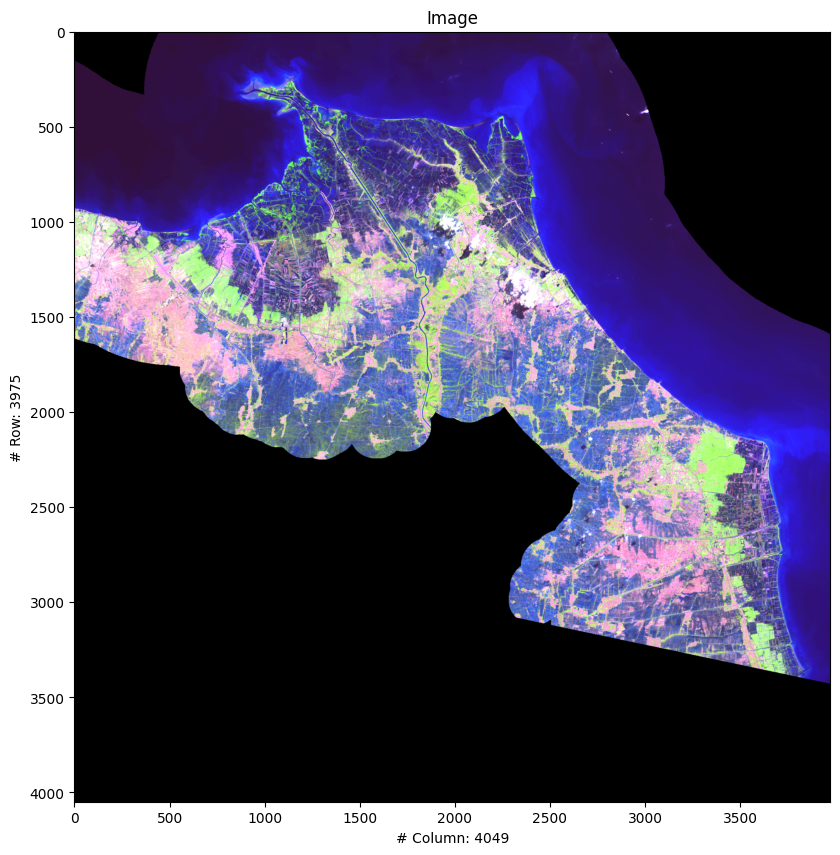

In [ ]:
plot_image(normalized_image, band_composite=band_composite, stretch=stretch)

##### Get a chip for testing

(5 extra if optional assignment is completed)

We want to now look at the different augmentations, outside of the data loader.  This will require running the function for getting the center index, and then converting to chips. You can then extract a chip to test different augmentation functions. You need a few ingredients here:

- Arguments:
    - patch_size = 256
    - overlap = 32
    - positive_class_threshold = 0.2
    - crop_ref = [mask, label]
- You will also need to divide patch_size in half correctly reference from cell center x, y to get the bounds of each chip.
- A list `coor` will be needed to catch the indices for x, y, which is the output from `patch_center_index`.
- A list to catch the image chips, and one to catch the label chips.
- To get an image chip you need to do something like this:

  ```python
  img_chips = []  # list to catch the chips
  half_win = patch_size // 2  # 1/2 patch size
  # subset image--note the extra dimension for the channel
  img_chips.append(img[x-half_win:x+half_win,   
                       y-half_win:y+half_win, :])
  ```

##### **Optional coding assignment 2**

(5 extra points)

Can you modify the chipping code to get the index of the upper left corner of each small chip, instead of getting the center point? If you decide to make the change make sure you also make appropriate changes when you are using those indices in the actual chipping process.

If you are going to do this, modify the function for getting the center index (call it `get_upperleft_index`) in the cell below. Run it instead of `get_center_index` when making your chips, both here and in the custom loader. Note that the advice above for making the chips will differ a bit also.

In [ ]:
### Add your indexing function here.  Otherwise leave as is.
# def get_upperleft_index(...):

def get_upperleft_index(image_shape, patch_size, overlap):
    """
    Calculate the upper-left indices for chipping an image.

    Parameters:
    - image_shape: tuple, shape of the image as (height, width).
    - patch_size: int, size of each chip (e.g., 256).
    - overlap: int, overlap between chips in pixels.

    Returns:
    - coor: list of tuples, each containing (x, y) upper-left indices.
    """
    stride = patch_size - overlap
    coor = []

    for x in range(0, image_shape[0] - patch_size + 1, stride):
        for y in range(0, image_shape[1] - patch_size + 1, stride):
            coor.append((x, y))  # Upper-left corner coordinates

    return coor

def chip_image(image, label, coor, patch_size):
    """
    Extract chips (patches) from the image and label arrays.

    Parameters:
    - image: numpy array, the input image (height, width, channels).
    - label: numpy array, the corresponding label (height, width).
    - coor: list of tuples, upper-left indices for the chips.
    - patch_size: int, size of each chip.

    Returns:
    - img_chips: list of numpy arrays, image chips.
    - lbl_chips: list of numpy arrays, label chips.
    """
    img_chips = []
    lbl_chips = []

    for (x, y) in coor:
        # Extract the image chip
        img_chip = image[x:x+patch_size, y:y+patch_size, :]
        img_chips.append(img_chip)

        # Extract the corresponding label chip
        lbl_chip = label[x:x+patch_size, y:y+patch_size]
        lbl_chips.append(lbl_chip)

    return img_chips, lbl_chips



**TA Comment**

Please check below correct implementation of chipping with upper left index:
```
def get_upperleft_index(cropping_ref, patch_size, overlap, usage,
                        positive_class_threshold=None, verbose=True):
    r"""
    Generate indices to divide the scene into small chips.
    Each index marks the upper-left corner of the corresponding chip.

    Arguments:
        cropping_ref (list): Reference raster layers, to be used to generate
            the index. In our case, it is the study area binary mask and label mask.
        patch_size (int): Size of each clipped patch.
        overlap (int): Amount of overlap (in pixels) between the extracted chips.
        usage (str): Either 'train' or 'val'. Chipping strategy is different for
            different usage.
        positive_class_threshold (float): A real value as a threshold for the
            proportion of positive class pixels to the total area of the chip.
            (Used only for training.)
        verbose (bool): If True, prints the detailed list of chip indices.

    Returns:
        List of indices where each index is [i, j] representing the upper-left corner
        of a chip.
    """
    assert usage in ["train", "val"]

    mask, label = cropping_ref

    # Determine the valid range for the upper-left corner so that a full chip fits.
    valid_pixels = np.argwhere(mask)
    i_min = int(np.min(valid_pixels[:, 0]))
    i_max = int(np.max(valid_pixels[:, 0])) - patch_size + 1
    j_min = int(np.min(valid_pixels[:, 1]))
    j_max = int(np.max(valid_pixels[:, 1])) - patch_size + 1

    # Define the step size (adjust overlap accordingly)
    step_size = patch_size - 2 * overlap

    positive_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    for j in range(j_min, j_max + 1, step_size):
        for i in range(i_min, i_max + 1, step_size):
            # Extract the chip from mask and label using (i, j) as upper-left corner.
            mask_ref = mask[i: i + patch_size, j: j + patch_size]
            label_ref = label[i: i + patch_size, j: j + patch_size]

            if usage == "train" and mask_ref.all():
                if label_ref.any():
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        positive_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])
            elif usage == "val" and label_ref.any() and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":
        num_negative_samples = min(math.ceil(0.2 * len(positive_patch_index)), 15)
        if neg_patch_index and len(neg_patch_index) >= num_negative_samples:
            neg_samples = random.sample(neg_patch_index, num_negative_samples)
            positive_patch_index.extend(neg_samples)
        selected_indices = positive_patch_index
    else:  # usage == "val"
        selected_indices = non_proportional_patch_index

    if verbose:
        print("Number of chips:", len(selected_indices))
        print("Chip upper-left corner indices:\n{}".format(selected_indices))

    return selected_indices
```



##### Apply chipping

In [ ]:
# index = #call the chipping function with proper arguments

patch_size = 256
overlap = 32
coor = get_upperleft_index(image_shape=image_array.shape[:2], patch_size=patch_size, overlap=overlap)

img_chips, lbl_chips = chip_image(image_array, lbl_array, coor, patch_size)



**TA Comment**

please check below:



```
index = patch_center_index(cropping_ref=[mask, label], patch_size=256, overlap=32, usage ="train", positive_class_threshold=0.2, verbose=True)
```

```
img_chips = []
lbl_chips = []
patch_size = 256

half_win = patch_size // 2

for center in index:
    x, y = center
    img_chips.append(normalized_img[x-half_win:x+half_win, y-half_win:y+half_win, :])
    lbl_chips.append(label[x-half_win:x+half_win, y-half_win:y+half_win])
```

##### Plot your selected chip

Select a single chip by index and then plot it--both the image and label chip.

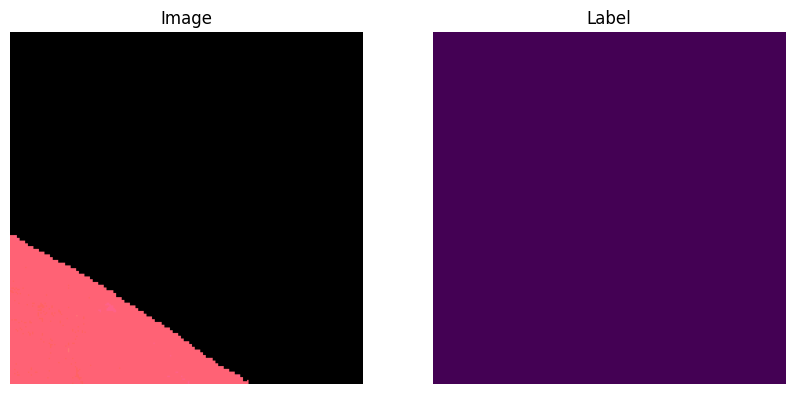

In [ ]:
plot_image_and_label(img_chips[0], lbl_chips[0], band_composite, stretch)

#### Augmentation 1


Run your first chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that.

##### Augmentation function (optional)

In [ ]:
### Add your first augmentation function here, if using a different function
# then those provided here. Otherwise, leave this as is

from scipy.ndimage import shift

def translate_image_and_label(image, label, shift_x, shift_y):
    """
    Applies translation augmentation to an image patch and label.

    Args:
        image (numpy array): The input image patch as a numpy array with shape (H, W, C).
        label (numpy array): The corresponding label as a numpy array with shape (H, W).
        shift_x (int or float): The shift distance in the x-axis (in pixels).
        shift_y (int or float): The shift distance in the y-axis (in pixels).

    Returns:
        tuple: Translated image and label as numpy arrays.
    """
    # Ensure image is translated with "reflect" mode to avoid edge artifacts
    translated_image = shift(image, shift=(shift_y, shift_x, 0), mode='reflect')

    # Translate the label with "nearest" mode to maintain categorical values
    translated_label = shift(label, shift=(shift_y, shift_x), mode='nearest')

    # Return the translated outputs
    return translated_image.copy(), translated_label.copy()

##### Apply augmentation

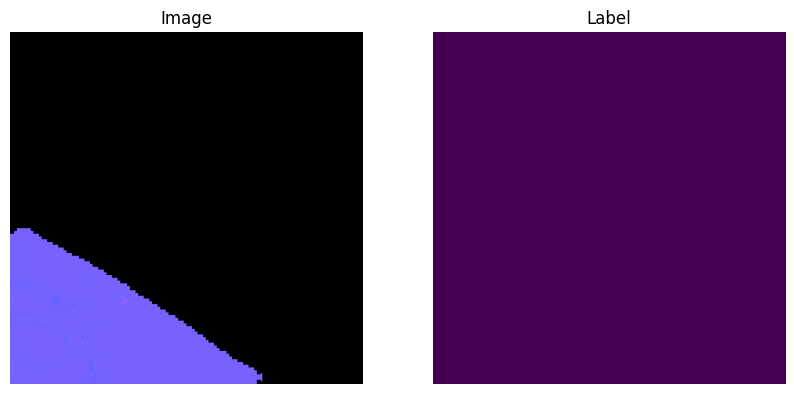

In [ ]:
### fill in augmentation code here

# Example: Apply translation augmentation to all image and label chips
def apply_translation_to_chips(img_chips, lbl_chips, shift_x, shift_y):
    """
    Applies translation augmentation to a list of image and label chips.

    Parameters:
    - img_chips: list of numpy arrays, image chips (H, W, C).
    - lbl_chips: list of numpy arrays, label chips (H, W).
    - shift_x: int, shift distance in the x-axis (in pixels).
    - shift_y: int, shift distance in the y-axis (in pixels).

    Returns:
    - translated_img_chips: list of translated image chips.
    - translated_lbl_chips: list of translated label chips.
    """
    translated_img_chips = []
    translated_lbl_chips = []

    for img_chip, lbl_chip in zip(img_chips, lbl_chips):
        # Apply the translation augmentation
        translated_img, translated_lbl = translate_image_and_label(img_chip, lbl_chip, shift_x, shift_y)
        translated_img_chips.append(translated_img)
        translated_lbl_chips.append(translated_lbl)

    return translated_img_chips, translated_lbl_chips

# Example usage
shift_x = 10  # Shift right by 10 pixels
shift_y = -5  # Shift up by 5 pixels

# Apply translation augmentation to all chips
translated_img_chips, translated_lbl_chips = apply_translation_to_chips(img_chips, lbl_chips, shift_x, shift_y)

# Visualize the results for the first chip
plot_image_and_label(translated_img_chips[0], translated_lbl_chips[0], band_composite=(0, 1, 2), stretch=True)


##### Plot your augmented chip

In [ ]:
plot_image_and_label(translated_img_chips)

TypeError: plot_image_and_label() missing 1 required positional argument: 'label_array'

**TA Comment**

When calling a function, you need to provide values for all of its required (positional) arguments—unless the function defines default values for them.

In this case, plot_image_and_label() expects two arguments: image_array and label_array.
You only passed one (translated_img_chips), so Python throws a TypeError, telling you that the second argument label_array is missing., check below:



```
plot_image_and_label(img_chips[0], lbl_chips[0], band_composite, stretch)
```



#### Augmentation 2

Run your second chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that.

##### Augmentation function (optional)

In [ ]:
#@title Gamma correction brightness shift to an image chip using "cv2"
def shift_brightness(img, gamma_range=(0.2, 2.0), shift_subset=(4, 4),
                     patch_shift=False):
    """
    Shift image brightness through gamma correction
    Params:
        img (ndarray): Concatenated variables or brightness value with a
            dimension of (H, W, C)
        gamma_range (tuple): Range of gamma values
        shift_subset (tuple): Number of bands or channels for each shift
        patch_shift (bool): Whether apply the shift on small patches
     Returns:
        ndarray, brightness shifted image
    """
    c_start = 0
    for i in shift_subset:
        gamma = random.triangular(gamma_range[0], gamma_range[1], 1)
        if patch_shift:
            # shift on patch
            # generate mask - random rotate or/and rescale

            h, w, _ = img.shape
            rotMtrx = cv2.getRotationMatrix2D(
                center=(random.randint(0, h), random.randint(0, w)),
                angle=random.randint(0, 90), scale=random.uniform(1, 2))
            mask = cv2.warpAffine(img[:, :, c_start:c_start + i],
                                  rotMtrx, (w, h))
            mask = np.where(mask, 0, 1)
            # apply mask
            img_ma = ma.masked_array(img[:, :, c_start:c_start + i], mask=mask)
            img[:, :, c_start:c_start + i] = ma.power(img_ma, gamma)
            # default extra step : shift on image
            gamma_full = random.triangular(0.5, 1.5, 1)
            img[:, :, c_start:c_start + i] = np.power(
                img[:, :, c_start:c_start + i], gamma_full
            )

        else:
            img[:, :, c_start:c_start + i] = np.power(
                img[:, :, c_start:c_start + i], gamma
            )
        c_start += i

    return img


In [ ]:
def apply_brightness_shift_to_chips(img_chips, gamma_range=(0.2, 2.0), patch_shift=False):
    """
    Applies brightness shift using gamma correction to a list of image chips.

    Parameters:
    - img_chips: list of numpy arrays, image chips (H, W, C).
    - gamma_range: tuple, range of gamma values for brightness adjustment.
    - patch_shift: bool, whether to apply patch-specific brightness shift.

    Returns:
    - shifted_img_chips: list of brightness-shifted image chips.
    """
    shifted_img_chips = []

    for img_chip in img_chips:
        # Apply brightness shift to the current chip
        shifted_img = shift_brightness(img_chip, gamma_range=gamma_range, patch_shift=patch_shift)
        shifted_img_chips.append(shifted_img)

    return shifted_img_chips


##### Apply second augmentation

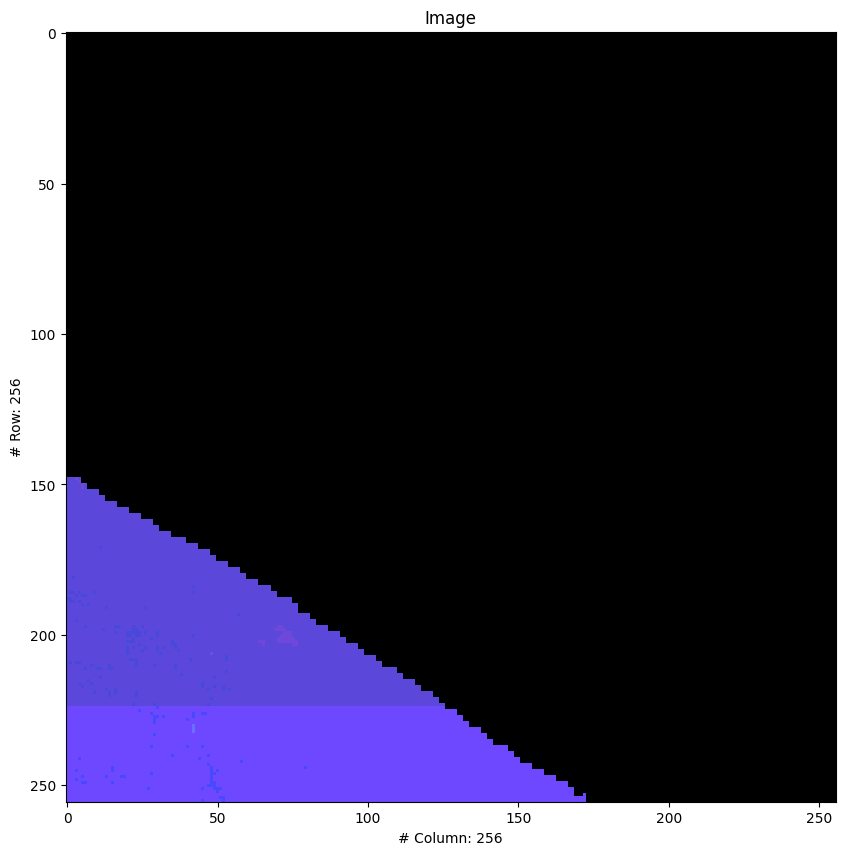

In [ ]:
### fill in augmentation code here
# Parameters for brightness shift
gamma_range = (0.5, 1.5)  # Adjust brightness with gamma values between 0.5 and 1.5
patch_shift = False       # Apply brightness shift to entire chips

# Apply brightness shift augmentation to all chips
shifted_img_chips = apply_brightness_shift_to_chips(img_chips, gamma_range=gamma_range, patch_shift=patch_shift)

# Example: Visualize the result for the first chip
plot_image(shifted_img_chips[0], band_composite=(0, 1, 2), stretch=True)


##### Plot your augmented chip

In [ ]:
plot_image_and_label(flipped_img, flipped_lbl, band_composite, stretch)

NameError: name 'flipped_img' is not defined

**TA Comment**

You will need to first apply the augmentation on a pair then run the plot, or use indexing to select one pair after applying the augmentation


#### Create and demonstrate your loader

##### Create your loader

Adapt the template below to create your custom data loader.

In [ ]:
# class ActiveLoadingDataset(Dataset):
#     def __init__(self, src_dir, csv_name, usage, patch_size, overlap,
#                  positive_class_threshold = 0.15, apply_normalization=True,
#                  transform=None, **kargs):
#         r"""
#         src_dir (str or path) : Root of resource directory.
#         csv_name (str) : Name of the csv file containing the input paths.
#         usage (str) : Either 'train' or 'validation'.
#         patch_size (int) : Size of each clipped patches.
#         overlap (int) : Amount of overlap (in pixels) between extracted chips.
#         positive_class_threshold (float) : A real value as a threshold for the
#             proportion of positive class to the total areal of the chip. Used to
#             decide if the chip should be considered as a positive chip in the
#             sampling process.
#         transform (list) -- Each element is string name of the transformation to
#              be used, e.g. ["rotate", "flip"]
#         """
#         self.src_dir = src_dir
#         self.csv_name = csv_name
#         self.overlap = overlap
#         self.positive_class_threshold=positive_class_threshold
#         self.transform = transform

#         self.usage = usage
#         assert self.usage in ["train", "validate"], "Usage is not recognized."

#         self.patch_size = patch_size
#         half_size = patch_size // 2

#         catalog = pd.read_csv(Path(src_dir) / csv_name)
#         self.catalog = catalog[catalog.usage==self.usage]

#         self.img_chips = []
#         self.lbl_chips = []
#         self.coor = []

#         img_path = self.catalog["img_dir"]
#         lbl_path = self.catalog["label_dir"]
#         mask_path = self.catalog["mask_dir"]

#         img =  #your code to load the image from img_path and make sure channel
#                # is the last dimension. Make sure to apply the transformation
#         lbl =  #your code to load the label from lbl_path
#         mask = #your code to load the mask from mask_path

#         crop_ref = [mask, lbl]

#         index = #call the chipping function with proper arguments

#         for i in range(len(index)):
#             x = index[i][0]
#             y = index[i][1]

#             self.coor.append([x, y])
#             #Use the x, y coordinates of the center indices to chip through the
#             # image and label and add each chip to its corresponding list. You
#             # need to properly index through the three dimensions of the image
#             # and two dimensions of the label.
#             self.img_chips.append(.............) #your code here
#             self.lbl_chips.append(.............) #your code here


#         msg = '--------------{} patches cropped--------------'
#         print(msg.format(len(self.img_chips)))


#     def __getitem__(self, index):

#         image_chip = self.img_chips[index]
#         label_chip = self.lbl_chips[index]

#         if self.usage == "train" and transform:

#             # revise lines 84-88 to add your augmentation of choice
#             # if applying flipping, make sure that the flip direction is
#             # randomly chosen also, which can be achieved using random choice
#             # from a list of the two directions.
#             if random.randint(0, 1) and "some_transformation" in transform:
#                  image_chip, label_chip = some_transformation(.....)

#             if (random.random() > 0.5) and "another_transformation" in transform:
#                  image_chip, label_chip = some_other_transformation(.....)


#         # Convert numpy arrays to torch tensors.
#         # Image chips should be: CHW if not transpose to correct order of
#         # dimensions.
#         image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
#         label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

#         return image_tensor, label_tensor

#     def __len__(self):

#         return #put your code here (this needs to count the number of chips)


import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import rasterio
import random
import os

class ActiveLoadingDataset(Dataset):
    def __init__(self, src_dir, csv_name, usage, patch_size, overlap,
                 positive_class_threshold=0.15, apply_normalization=True, transform=None):
        """
        Custom dataset for active loading with chipping, normalization, and augmentations.

        Args:
            src_dir (str or path): Root of resource directory.
            csv_name (str): Name of the CSV file containing the input paths.
            usage (str): Either 'train' or 'validate'.
            patch_size (int): Size of each chip (e.g., 256x256).
            overlap (int): Amount of overlap (in pixels) between extracted chips.
            positive_class_threshold (float): Threshold for positive class in chips.
            apply_normalization (bool): Whether to apply normalization to images.
            transform (list): List of transformations/augmentations to apply.
        """
        self.src_dir = src_dir
        self.csv_name = csv_name
        self.usage = usage
        self.patch_size = patch_size
        self.overlap = overlap
        self.positive_class_threshold = positive_class_threshold
        self.apply_normalization = apply_normalization
        self.transform = transform

        assert self.usage in ["train", "validate"], "Usage must be 'train' or 'validate'."

        # Load catalog and filter based on usage
        catalog = pd.read_csv(os.path.join(self.src_dir, self.csv_name))
        self.catalog = catalog[catalog.usage == self.usage]

        # Initialize lists for chips and coordinates
        self.img_chips = []
        self.lbl_chips = []
        self.coor = []

        # Load images, labels, and masks
        img_path = os.path.join(self.src_dir, self.catalog["img_dir"].iloc[0])
        lbl_path = os.path.join(self.src_dir, self.catalog["label_dir"].iloc[0])
        mask_path = os.path.join(self.src_dir, self.catalog["mask_dir"].iloc[0])

        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32).transpose(1, 2, 0)
        with rasterio.open(lbl_path) as src:
            lbl = src.read(1)
        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        # Normalize the image
        if self.apply_normalization:
            img = self.min_max_normalize_image_wclip(img, clip_threshold=1)

        # Generate chips and coordinates
        self.coor = self.get_upperleft_index(img.shape[:2], self.patch_size, self.overlap)
        self.img_chips, self.lbl_chips = self.chip_image(img, lbl, self.coor, self.patch_size)

        print(f"--------------{len(self.img_chips)} patches cropped--------------")

    def min_max_normalize_image_wclip(self, image, clip_threshold=1):
        lower, upper = np.percentile(image, [clip_threshold, 100 - clip_threshold])
        clipped_image = np.clip(image, lower, upper)
        return (clipped_image - lower) / (upper - lower)

    def get_upperleft_index(self, image_shape, patch_size, overlap):
        stride = patch_size - overlap
        coor = []
        for x in range(0, image_shape[0] - patch_size + 1, stride):
            for y in range(0, image_shape[1] - patch_size + 1, stride):
                coor.append((x, y))
        return coor

    def chip_image(self, image, label, coor, patch_size):
        img_chips = []
        lbl_chips = []
        for (x, y) in coor:
            img_chip = image[x:x+patch_size, y:y+patch_size, :]
            lbl_chip = label[x:x+patch_size, y:y+patch_size]
            img_chips.append(img_chip)
            lbl_chips.append(lbl_chip)
        return img_chips, lbl_chips

    def __len__(self):
        return len(self.img_chips)

    def __getitem__(self, index):
        image_chip = self.img_chips[index]
        label_chip = self.lbl_chips[index]

        # Apply augmentations if in training mode
        if self.usage == "train" and self.transform:
            for transform in self.transform:
                if transform == "flip" and random.random() > 0.5:
                    if random.choice(["horizontal", "vertical"]) == "horizontal":
                        image_chip = np.fliplr(image_chip)
                        label_chip = np.fliplr(label_chip)
                    else:
                        image_chip = np.flipud(image_chip)
                        label_chip = np.flipud(label_chip)
                elif transform == "brightness_shift" and random.random() > 0.5:
                    gamma = random.uniform(0.8, 1.2)  # Example gamma range
                    image_chip = np.power(image_chip, gamma)

        # Convert to PyTorch tensors
        image_tensor = torch.from_numpy(image_chip.transpose(2, 0, 1)).float()
        label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

        return image_tensor, label_tensor


**TA Comment**

please check below corrected dataloader:

```
class ActiveLoadingDataset(Dataset):
    def __init__(self, src_dir, csv_name, usage, patch_size, overlap, 
                 positive_class_threshold = 0.15, apply_normalization=True, 
                 transform=None, **kargs):
        r"""
        src_dir (str or path) : Root of resource directory.
        csv_name (str) : Name of the csv file containing the input paths.
        usage (str) : Either 'train' or 'validation'.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : Amount of overlap (in pixels) between extracted chips.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
        transform (list) -- Each element is string name of the transformation to
             be used, e.g. ["rotate", "flip"]
        """
        self.src_dir = src_dir
        self.csv_name = csv_name
        self.overlap = overlap
        self.positive_class_threshold=positive_class_threshold
        self.transform = transform
        
        self.usage = usage
        assert self.usage in ["train", "validate"], "Usage is not recognized."
        #set_trace()

        self.patch_size = patch_size
        half_size = patch_size // 2

        catalog = pd.read_csv(Path(src_dir) / csv_name)
        self.catalog = catalog[catalog.usage==self.usage]

        self.img_chips = []
        self.lbl_chips = []
        self.coor = []
                
        img_path = self.catalog["img_dir"].tolist()[0]
        lbl_path = self.catalog["label_dir"].tolist()[0]
        mask_path = self.catalog["mask_dir"].tolist()[0]
        

       
        with rasterio.open(os.path.join(src_dir, img_path)) as src:
          img = src.read()
          img = min_max_normalize_image_wclip(img)
          img = img.transpose(1, 2, 0)
        
        
        with rasterio.open(os.path.join(src_dir, lbl_path)) as src:
          lbl = src.read(1)
          
        with rasterio.open(os.path.join(src_dir, mask_path)) as src:
          mask = src.read(1)
          

        crop_ref = [mask, lbl]

        #call the chipping function with proper arguments
        index =  patch_center_index(cropping_ref=[mask, lbl],
                                    patch_size=self.patch_size,
                                    overlap=self.overlap, usage =self.usage,
                                    positive_class_threshold=self.positive_class_threshold,
                                    verbose=True)

        for i in range(len(index)):
            x = index[i][0]
            y = index[i][1]

            self.coor.append([x, y])
            #Use the x, y coordinates of the center indices to chip through the 
            # image and label and add each chip to its corresponding list. You 
            # need to properly index through the three dimensions of the image
            # and two dimensions of the label.
            self.img_chips.append(img[x-half_size:x+half_size, y-half_size:y+half_size, :])
            self.lbl_chips.append(lbl[x-half_size:x+half_size, y-half_size:y+half_size])

            
        msg = '--------------{} patches cropped--------------'
        print(msg.format(len(self.img_chips)))
        

    def __getitem__(self, index):

        image_chip = self.img_chips[index]
        label_chip = self.lbl_chips[index]

        if self.usage == "train" and transform:

            # revise lines 84-88 to add your augmentation of choice
            # if applying flipping, make sure that the flip direction is 
            # randomly chosen also, which can be achieved using random choice 
            # from a list of the two directions.  
            if random.randint(0, 1) and "rotation_transformation" in transform:
                 image_chip, label_chip = rotate_image_and_label(img_chips[i], lbl_chips[i], (0, 90))

            trans_flip_ls = [m for m in self.transform if "flip" in m]
            if random.randint(0, 1) and len(trans_flip_ls) > 1:
                trans_flip = random.sample(trans_flip_ls, 1)
            image_chip, label_chip = flip_image_and_label(img_chip, lbl_chip, trans_flip[0])
                        

        # Convert numpy arrays to torch tensors.
        # Image chips should be: CHW if not transpose to correct order of 
        # dimensions.
        image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
        label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

        return image_tensor, label_tensor

    def __len__(self):

        #put your code here (this needs to count the number of chips)
        return len(self.img_chips)
```

##### Demonstrate your loader

Use/adapt the following arguments to run code.

In [ ]:
src_dir = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data"
csv_name = "pond_scenes_train_val.csv"
usage = "train"
patch_size = 256
overlap = 32
positive_class_threshold = 0.2
apply_normalization = True
transform = ["brightness shift", "translation"] # fill list with your transforms

###### Training dataset

In [ ]:
train_dataset = ActiveLoadingDataset(
    src_dir, csv_name, usage, patch_size, overlap,
    positive_class_threshold, apply_normalization, transform
)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

--------------289 patches cropped--------------


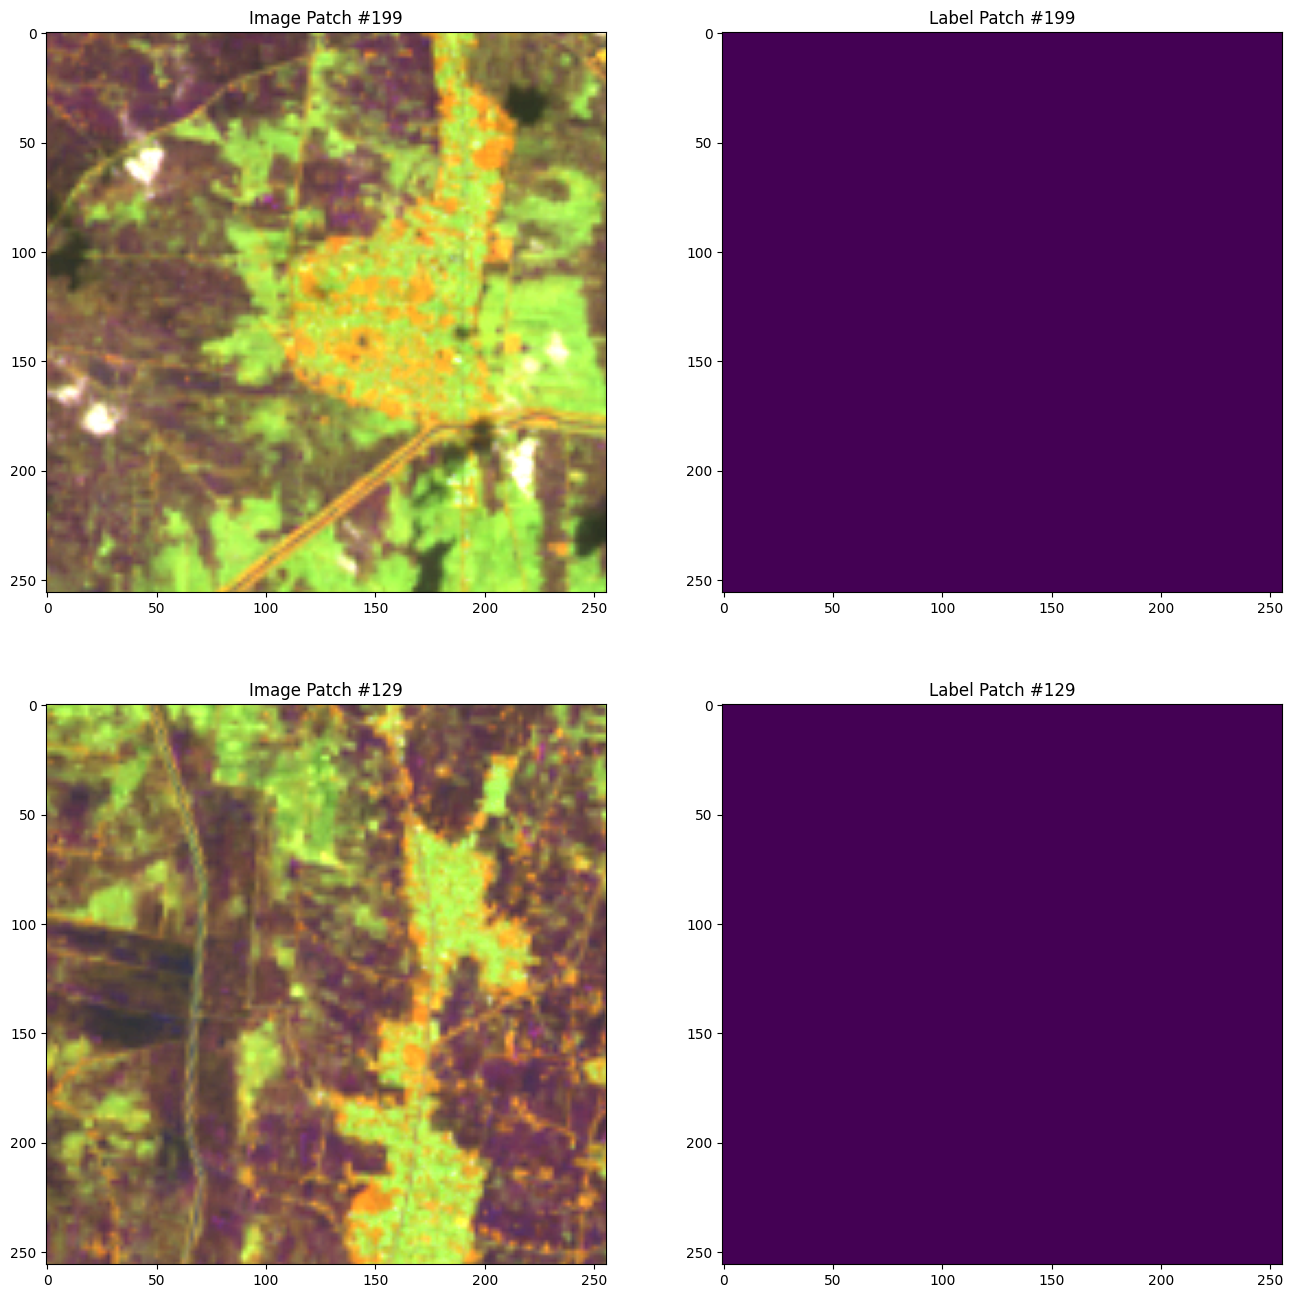

In [ ]:
show_random_patches(train_dataset, sample_num=2, rgb_bands=(0, 1, 2))

###### Validation dataset

In [ ]:
### Update the code to run the loader for the validation dataset

# from torch.utils.data import DataLoader

# Instantiate the ActiveLoadingDataset for validation
validation_dataset = ActiveLoadingDataset(
    src_dir="/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data",  # Replace with your actual src_dir path
    csv_name="pond_scenes_train_val.csv",  # Ensure the CSV is located here
    usage="validate",  # Validation mode
    patch_size=256,
    overlap=32,
    positive_class_threshold=0.15,  # Can be adjusted as needed
    apply_normalization=True,  # Apply normalization for validation
    transform=None  # No augmentations applied during validation
)

# Create a DataLoader for the validation dataset
validation_loader = DataLoader(
    validation_dataset,
    batch_size=8,  # Number of chips per batch
    shuffle=False,  # No need to shuffle for validation
    num_workers=2  # Adjust based on your system capability
)

# Iterate through the validation loader and inspect the data
for batch in validation_loader:
    images, labels = batch
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break  # Only inspect the first batch


--------------756 patches cropped--------------
Image batch shape: torch.Size([8, 3, 256, 256])
Label batch shape: torch.Size([8, 256, 256])


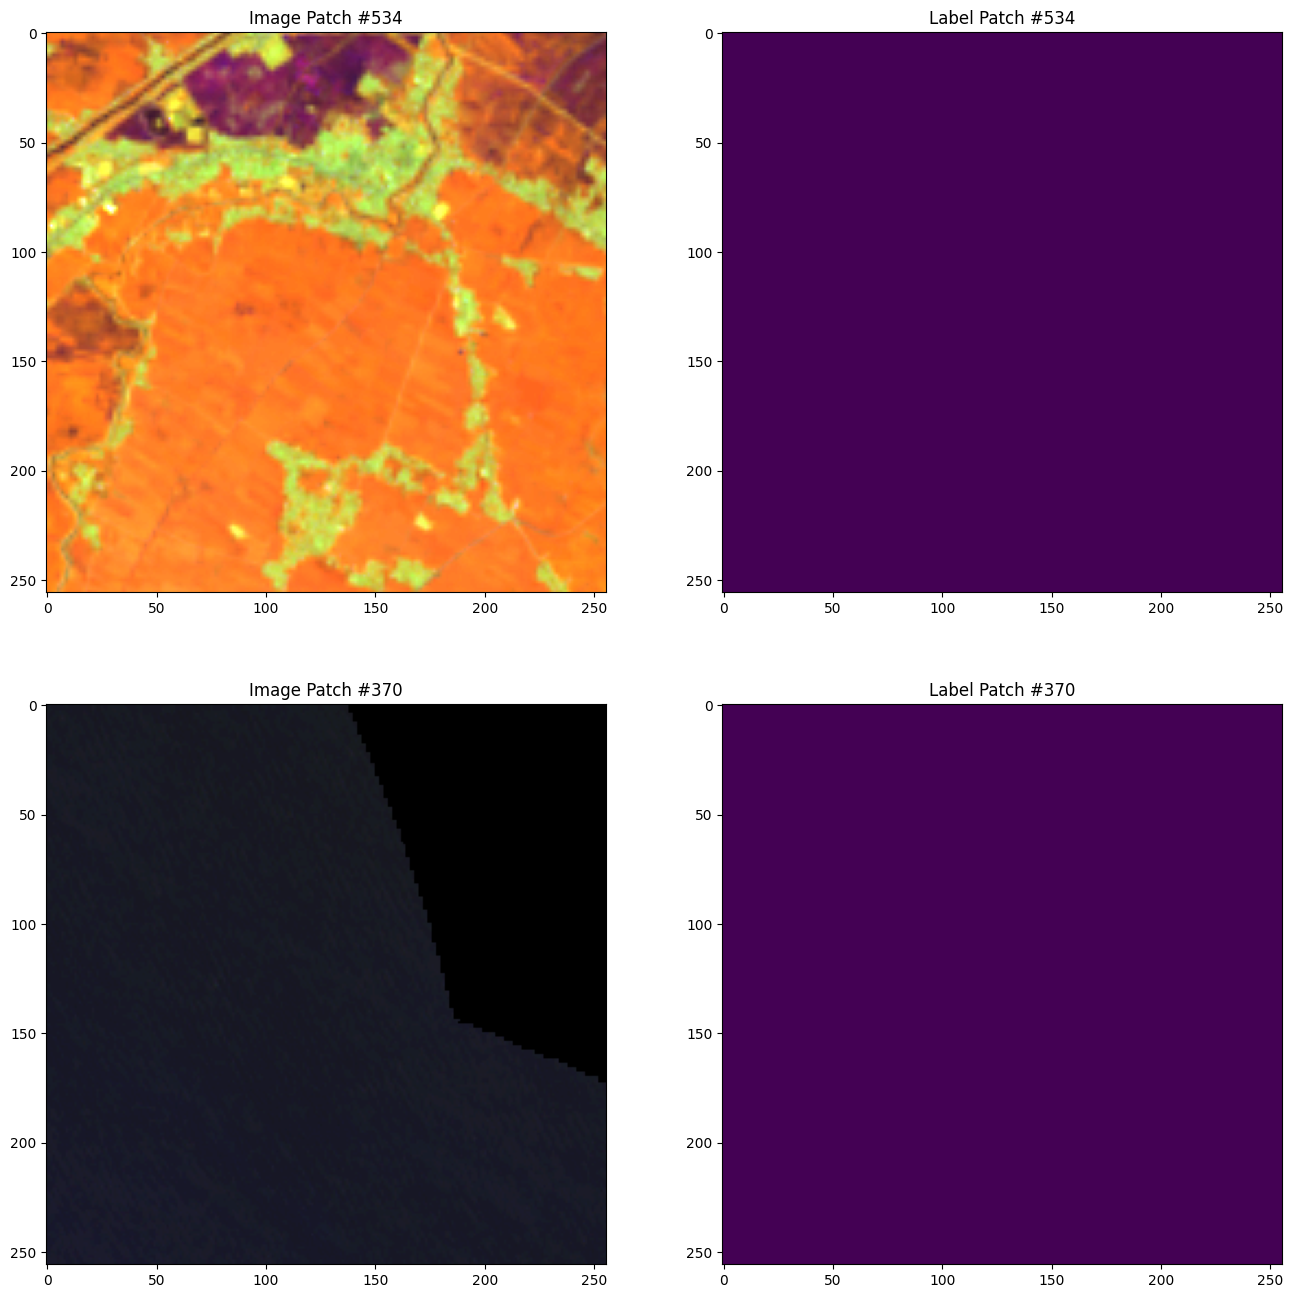

In [ ]:
show_random_patches(validation_dataset, sample_num=2, rgb_bands=(0, 1, 2))

In [ ]:
# # My copilot conversation for debugging and filling in code:

# i need to adapt the highlighted code to an actual path in my google drive, how do i figure out how to get that syntax exactly right?
# To adapt the code to your Google Drive path, you'll need to mount your Google Drive in Colab and then navigate to the correct directory. Here's how you can do it:

# Mount Google Drive: Use the following code snippet to mount your Google Drive:

# python
# from google.colab import drive
# drive.mount('/content/drive')
# Locate Your File Path: After mounting, your Google Drive will be accessible under /content/drive/MyDrive/. You can use the !ls command to explore directories and find the exact path:

# python
# !ls /content/drive/MyDrive/
# Update the Path in Your Code: Replace the placeholder path in your code with the actual path to your file or folder. For example:

# python
# src_dir = "/content/drive/MyDrive/path_to_your_folder/"
# If you're still unsure about the exact path, you can open your Google Drive in a browser, navigate to the file or folder, and note its location relative to "My Drive." Let me know if you need help with a specific part of this process!

# im getting this error: FileNotFoundError: [Errno 2] No such file or directory: '/MyDrive/adleo/data/assn3/assignment3_data/pond_scenes_train_val.csv' my path is /MyDrive/adleo/data/assn3/assignment3_data
# The error occurs because the code you’re running is likely expecting the full path to the file, but the path provided might be missing the /content/drive prefix required after mounting Google Drive in Colab.

# To resolve this, update the path like this:

# python
# src_dir = "/content/drive/MyDrive/adleo/data/assn3/assignment3_data"
# csv_name = "pond_scenes_train_val.csv"
# catalog = pd.read_csv(os.path.join(src_dir, csv_name))
# In this corrected version, the path starts with /content/drive/MyDrive because that’s where Google Drive is mounted when using Colab. You can adapt this same format for other file paths.

# Give this a try, and let me know if the error persists or if you need more clarification!

# now i got this error: FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/adleo/data/assn3/assignment3_data/pond_scenes_train_val.csv' my mounting code is from google.colab import drive drive.mount("/content/gdrive")
# The mismatch arises because your current mount point is /content/gdrive, but the path you're using begins with /content/drive. To fix the issue, adjust the file path to align with your mount point.

# Your updated code should look like this:

# python
# src_dir = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data"
# csv_name = "pond_scenes_train_val.csv"
# catalog = pd.read_csv(os.path.join(src_dir, csv_name))
# Notice how /content/drive is replaced with /content/gdrive to reflect your actual mount point. This should resolve the FileNotFoundError.

# Let me know if you encounter any other hiccups!

# that worked thanks
# You're welcome, Andrew! I'm glad it worked out. If you run into any other roadblocks, feel free to reach out—I'll be happy to help. What's next on your project?

# Modify the min-max input normalization (min_max_normalize_image) to clip the tail distributions based on a "clip_threshold" argument. For instance, trim of the 1st and 99th percentile values in each image. To do this, modify the min_max_normalize_image function cell below, renaming it min_max_normalize_image_wclip. Run it instead of min_max_normalize_image when normalizing your image (we recommend applying a 1% clip to either tail), both here and in the custom loader.
# To modify the min_max_normalize_image function to include clipping of the tail distributions, you can use the numpy.percentile function to calculate the 1st and 99th percentile values based on the clip_threshold. Here's how you can implement it:

# python
# import numpy as np

# def min_max_normalize_image_wclip(image, clip_threshold=1):
#     """
#     Normalizes the input image with min-max normalization and clips the tail distributions.

#     Parameters:
#     - image: numpy array representing the input image.
#     - clip_threshold: float, percentage of tails to clip from both ends (default is 1%).

#     Returns:
#     - normalized_image: numpy array, normalized and clipped image.
#     """
#     # Calculate clipping thresholds
#     lower_bound = np.percentile(image, clip_threshold)
#     upper_bound = np.percentile(image, 100 - clip_threshold)

#     # Clip the image to these bounds
#     clipped_image = np.clip(image, lower_bound, upper_bound)

#     # Min-max normalization
#     normalized_image = (clipped_image - clipped_image.min()) / (clipped_image.max() - clipped_image.min())

#     return normalized_image
# How it works:
# Clipping: The np.percentile function is used to determine the values at the clip_threshold (e.g., 1% and 99%). The np.clip function then ensures all values are within this range.

# Normalization: After clipping, min-max normalization is applied to scale the values between 0 and 1.

# Steps to Proceed:
# Replace your existing min_max_normalize_image function with the new min_max_normalize_image_wclip function in the appropriate cell.

# Ensure you pass the desired clip_threshold (e.g., 1 for 1% clipping).

# Use min_max_normalize_image_wclip in place of the original function wherever needed, including the custom loader.

# Let me know if you'd like further assistance! Would you also like to see an example of applying this function to an image?

# okay now take that code you gave and debug it/make it more simple and more efficient
# Here’s a simplified and optimized version of the code for min_max_normalize_image_wclip. I’ve made it more concise while ensuring it still accomplishes clipping and normalization efficiently:

# python
# import numpy as np

# def min_max_normalize_image_wclip(image, clip_threshold=1):
#     """
#     Applies min-max normalization with optional clipping to the input image.

#     Parameters:
#     - image: numpy array representing the input image.
#     - clip_threshold: float, percentage of tails to clip (default is 1%).

#     Returns:
#     - Normalized image as a numpy array.
#     """
#     # Clip the tails based on the specified percentile threshold
#     lower, upper = np.percentile(image, [clip_threshold, 100 - clip_threshold])
#     clipped_image = np.clip(image, lower, upper)

#     # Perform min-max normalization
#     return (clipped_image - lower) / (upper - lower)
# Key Improvements:
# Single np.percentile Call: The percentiles for clipping are calculated in one call with a [clip_threshold, 100 - clip_threshold] list, reducing computation overhead.

# Direct Normalization: By using lower and upper directly in the normalization step, we avoid recalculating min/max values unnecessarily.

# This approach keeps the code clean, readable, and efficient. Let me know if you'd like to test it or adapt it further!

# now consider the code on this page and give me the code to run that normalization on the image
# Based on the context of your current project and the min_max_normalize_image_wclip function defined earlier, here is how you can apply that normalization to an image, utilizing the structure and imports already provided in the notebook:

# python
# import rasterio
# import numpy as np

# def normalize_image_with_clipping(image_path, clip_threshold=1):
#     """
#     Loads an image, applies clipping and min-max normalization.

#     Parameters:
#     - image_path: str, path to the image file.
#     - clip_threshold: float, percentage of tails to clip (default is 1%).

#     Returns:
#     - normalized_image: numpy array, normalized and clipped image.
#     """
#     # Open the image using rasterio
#     with rasterio.open(image_path) as src:
#         # Read all bands of the image
#         image = src.read().astype(float)
#         # Reshape image to have the last axis as channels
#         image = image.transpose(1, 2, 0)

#         # Apply clipping and normalization for each band
#         normalized_image = np.empty_like(image)
#         for i in range(image.shape[2]):  # Loop through channels
#             band = image[:, :, i]
#             lower, upper = np.percentile(band, [clip_threshold, 100 - clip_threshold])
#             clipped_band = np.clip(band, lower, upper)
#             normalized_image[:, :, i] = (clipped_band - lower) / (upper - lower)

#     return normalized_image
# Steps:
# Input: Pass the file path of your image (e.g., img_path) to the function.

# Normalization: Each band (channel) is normalized independently, ensuring that the clipping is correctly applied before scaling the values to [0, 1].

# Transpose: The code transposes the dimensions of the image for compatibility with the visualization or model training pipelines.

# Here’s an example of how to call and use the function:

# python
# # Define the path to the image file
# img_path = os.path.join(src_dir, catalog[catalog.usage == 'train']['img_dir'][0])

# # Apply normalization
# normalized_image = normalize_image_with_clipping(img_path, clip_threshold=1)

# # Plot the normalized image
# plot_image(normalized_image, band_composite=(0, 1, 2), stretch=True)
# Let me know if you need adjustments or further clarification!

# now output that code again but make it more efficient and resistant to bugs
# Here is an updated and optimized version of the code for normalizing an image using min-max normalization with clipping. I've made it even more concise, robust, and resistant to potential issues:

# python
# import rasterio
# import numpy as np
# import os

# def normalize_image_with_clipping(image_path, clip_threshold=1):
#     """
#     Loads an image, applies percentile-based clipping and min-max normalization.

#     Parameters:
#     - image_path: str, path to the image file.
#     - clip_threshold: float, percentage of tails to clip (default is 1%).

#     Returns:
#     - normalized_image: numpy array, normalized and clipped image.
#     """
#     try:
#         # Open the image using rasterio
#         with rasterio.open(image_path) as src:
#             image = src.read().astype(np.float32)  # Read all bands and cast to float32
#             image = image.transpose(1, 2, 0)  # Ensure channels are last for processing

#         # Initialize an array to store the normalized bands
#         normalized_image = np.empty_like(image)

#         # Process each band independently
#         for i in range(image.shape[2]):  # Iterate over channels
#             band = image[:, :, i]

#             # Calculate clipping bounds
#             lower, upper = np.percentile(band, [clip_threshold, 100 - clip_threshold])

#             # Clip and normalize the band
#             band = np.clip(band, lower, upper)  # Clip values
#             if upper > lower:  # Prevent division by zero
#                 band = (band - lower) / (upper - lower)
#             else:
#                 band = np.zeros_like(band)  # Handle edge cases where all values are the same

#             normalized_image[:, :, i] = band

#         return normalized_image

#     except Exception as e:
#         print(f"Error processing the image: {e}")
#         return None
# Improvements:
# Error Handling: Added a try-except block to gracefully handle any errors (e.g., invalid file paths or corrupted images).

# Division-by-Zero Prevention: Included a check to avoid division by zero in case the upper and lower clipping bounds are equal.

# Dynamic Data Type: Ensured astype(np.float32) for robust numerical operations.

# Efficient Processing: Used np.empty_like to preallocate memory for the output array, improving efficiency.

# Example Usage:
# python
# # Path to your image file
# img_path = os.path.join(src_dir, catalog[catalog.usage == 'train']['img_dir'].iloc[0])

# # Normalize the image with 1% clipping on both tails
# normalized_image = normalize_image_with_clipping(img_path, clip_threshold=1)

# # Plot or use the normalized image
# plot_image(normalized_image, band_composite=(0, 1, 2), stretch=True)
# This version is both streamlined and resistant to common issues like invalid input or unexpected data conditions. Let me know if you’d like further refinements or examples!

# now help me with this step: # Write your code for applying normalization here. Probably easiest to read in # the image again, normalize, and then transpose
# Here’s a concise implementation for applying the normalization process, following the steps described. This will load the image, normalize it using the normalize_image_with_clipping function we created, and then transpose it into the required format:

# python
# import os

# def apply_normalization(img_path, clip_threshold=1):
#     """
#     Reads an image, applies normalization, and transposes it for further processing.

#     Parameters:
#     - img_path: str, path to the image file.
#     - clip_threshold: float, percentage for clipping (default is 1%).

#     Returns:
#     - normalized_image: numpy array, normalized and transposed image.
#     """
#     try:
#         # Normalize the image
#         normalized_image = normalize_image_with_clipping(img_path, clip_threshold)

#         # Transpose to (channels, height, width) if required by your pipeline
#         normalized_image = normalized_image.transpose(2, 0, 1)

#         return normalized_image
#     except Exception as e:
#         print(f"Error during normalization: {e}")
#         return None

# # Example usage
# img_path = os.path.join(src_dir, catalog[catalog.usage == 'train']['img_dir'].iloc[0])
# normalized_image = apply_normalization(img_path, clip_threshold=1)

# # Confirm results
# if normalized_image is not None:
#     print("Normalization applied successfully!")
# else:
#     print("Failed to normalize the image.")
# Explanation:
# Input Path: The img_path points to the specific image you want to normalize.

# Normalization: It calls normalize_image_with_clipping to apply clipping and normalization.

# Transpose: The output image is transposed to ensure the channels are the first dimension, which is typical for deep learning frameworks like PyTorch.

# Error Handling: A try-except block ensures the process is robust to file errors or unexpected issues.

# You can now proceed to use the normalized_image for visualization or further processing, such as data augmentation or model training. Let me know if you need help with the next steps!

# keep in mind that this is my normalization code: def min_max_normalize_image_wclip(image, clip_threshold=1): """ Applies min-max normalization with optional clipping to the input image. Parameters: - image: numpy array representing the input image. - clip_threshold: float, percentage of tails to clip (default is 1%). Returns: - Normalized image as a numpy array. """ # Clip the tails based on the specified percentile threshold lower, upper = np.percentile(image, [clip_threshold, 100 - clip_threshold]) clipped_image = np.clip(image, lower, upper) # Perform min-max normalization return (clipped_image - lower) / (upper - lower)
# Got it! Keeping your min_max_normalize_image_wclip function in mind, here's how you can write the code to apply this normalization. It will read in the image, apply normalization using your code, and transpose it as needed:

# python
# import rasterio
# import numpy as np

# def load_and_normalize_image(img_path, clip_threshold=1):
#     """
#     Loads an image, applies normalization with clipping, and transposes for further processing.

#     Parameters:
#     - img_path: str, path to the image file.
#     - clip_threshold: float, percentage of tails to clip (default is 1%).

#     Returns:
#     - normalized_image: numpy array, normalized and transposed image.
#     """
#     try:
#         # Open the image using rasterio
#         with rasterio.open(img_path) as src:
#             # Read all bands and cast to float for computation
#             image = src.read().astype(np.float32)

#         # Normalize each band independently
#         normalized_image = np.empty_like(image)
#         for i in range(image.shape[0]):  # Loop through each channel (band)
#             normalized_image[i] = min_max_normalize_image_wclip(image[i], clip_threshold)

#         # Transpose the dimensions to (height, width, channels) if required
#         return normalized_image.transpose(1, 2, 0)

#     except Exception as e:
#         print(f"Error in loading or normalizing the image: {e}")
#         return None

# # Example usage:
# img_path = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data/your_image_file.tif"  # Replace with your image path
# normalized_image = load_and_normalize_image(img_path, clip_threshold=1)

# if normalized_image is not None:
#     print("Normalization and transposition successful!")
# else:
#     print("Failed to process the image.")
# Explanation:
# Image Loading: The rasterio library is used to read the image and its individual bands as a NumPy array. The .astype(np.float32) ensures numerical stability during processing.

# Normalization: Your min_max_normalize_image_wclip function is applied to each band individually to clip and normalize values.

# Transposition: The final image is transposed from (channels, height, width) to (height, width, channels), if your pipeline requires this format.

# This code seamlessly integrates your function and handles any potential errors. Let me know how it works or if you'd like further tweaks!

# okay im getting errors, lets start from the beginning. This is my first set of instructions: Modify the min-max input normalization (min_max_normalize_image) to clip the tail distributions based on a "clip_threshold" argument. For instance, trim of the 1st and 99th percentile values in each image. To do this, modify the min_max_normalize_image function cell below, renaming it min_max_normalize_image_wclip. Run it instead of min_max_normalize_image when normalizing your image (we recommend applying a 1% clip to either tail), both here and in the custom loader. with this beginner code: ## Modify the normalization function here. Otherwise leave as is. # def min_max_normalize_image_wclip(...):
# Got it! Let's start from the beginning. Here's how you can modify the normalization function to clip the tail distributions as per your instructions:

# python
# import numpy as np

# def min_max_normalize_image_wclip(image, clip_threshold=1):
#     """
#     Applies min-max normalization with optional clipping to the input image.

#     Parameters:
#     - image: numpy array representing the input image.
#     - clip_threshold: float, percentage of tails to clip (default is 1%).

#     Returns:
#     - Normalized image as a numpy array.
#     """
#     # Compute the clipping bounds based on percentiles
#     lower, upper = np.percentile(image, [clip_threshold, 100 - clip_threshold])

#     # Clip the values to the specified bounds
#     clipped_image = np.clip(image, lower, upper)

#     # Apply min-max normalization
#     normalized_image = (clipped_image - lower) / (upper - lower)

#     return normalized_image
# What This Does:
# Calculate Percentiles: It determines the values at the clip_threshold and 100 - clip_threshold percentiles of the input image.

# Clipping: Any pixel values below the lower bound or above the upper bound are clipped to those bounds.

# Normalization: After clipping, the pixel values are scaled to a range of [0, 1].

# Next Steps:
# Copy this function and paste it into the appropriate cell in your notebook.

# Replace any instance of min_max_normalize_image with min_max_normalize_image_wclip.

# When calling the function, pass a clip_threshold of 1 (for 1% clipping on both ends).

# Let me know if you need assistance applying it or troubleshooting further!

# how can i confirm that this function is written correctly?
# To confirm that your min_max_normalize_image_wclip function is written correctly, you can perform the following steps:

# 1. Create a Test Array
# Use a small sample NumPy array with known values to test the function. This helps you verify whether clipping and normalization work as expected.

# python
# import numpy as np

# # Create a test array
# test_array = np.array([
#     [10, 20, 30],
#     [40, 50, 60],
#     [70, 80, 90]
# ], dtype=float)

# # Apply your function with a clip_threshold
# normalized_array = min_max_normalize_image_wclip(test_array, clip_threshold=10)

# print("Original Array:")
# print(test_array)
# print("\nNormalized Array:")
# print(normalized_array)
# For this example, you can manually calculate what the clipped and normalized results should look like and compare them to the function’s output.

# 2. Visualize the Results (Optional for Images)
# If you're working with image data, use a library like matplotlib to visualize the original and normalized images.

# python
# import matplotlib.pyplot as plt

# # Test with a random image-like array
# test_image = np.random.randint(0, 255, (100, 100), dtype=np.uint8)

# # Normalize the image
# normalized_image = min_max_normalize_image_wclip(test_image, clip_threshold=1)

# # Plot the original and normalized images
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(test_image, cmap="gray")
# plt.colorbar()

# plt.subplot(1, 2, 2)
# plt.title("Normalized Image")
# plt.imshow(normalized_image, cmap="gray")
# plt.colorbar()

# plt.show()
# 3. Edge Case Testing
# Try feeding the function some edge cases to ensure it handles these scenarios properly:

# Uniform array (e.g., np.full((3, 3), 50)).

# Extremely large or small values (e.g., np.array([1e6, 1e-6])).

# Arrays where the clip_threshold results in the same lower and upper values.

# python
# # Uniform array test
# uniform_array = np.full((3, 3), 50, dtype=float)
# result = min_max_normalize_image_wclip(uniform_array, clip_threshold=10)
# print("Uniform Array Normalization Result:", result)

# # Extreme values test
# extreme_array = np.array([1e6, 1e-6, 50], dtype=float)
# result = min_max_normalize_image_wclip(extreme_array, clip_threshold=1)
# print("Extreme Array Normalization Result:", result)
# 4. Check Output Ranges
# After running the function, confirm that the output values are in the range [0, 1].

# python
# # Verify range of the normalized output
# assert normalized_array.min() >= 0, "Minimum value is less than 0"
# assert normalized_array.max() <= 1, "Maximum value is greater than 1"
# print("Output range is correct (0 to 1).")
# 5. Log Debug Information
# Add print statements or logging to the function itself to track intermediate steps like lower, upper, clipped_image, etc., and ensure they're calculated as expected:

# python
# def min_max_normalize_image_wclip(image, clip_threshold=1):
#     lower, upper = np.percentile(image, [clip_threshold, 100 - clip_threshold])
#     print(f"Lower Bound: {lower}, Upper Bound: {upper}")  # Debug info
#     clipped_image = np.clip(image, lower, upper)
#     print(f"Clipped Image:\n{clipped_image}")  # Debug info
#     normalized_image = (clipped_image - lower) / (upper - lower)
#     return normalized_image
# Following these steps will help you confirm the correctness of your function and its robustness to various scenarios. Let me know if you'd like help interpreting any test results!

# does this look right? Original Array: [[10. 20. 30.] [40. 50. 60.] [70. 80. 90.]] Normalized Array: [[0. 0.03125 0.1875 ] [0.34375 0.5 0.65625] [0.8125 0.96875 1. ]]
# Yes, that looks correct based on your normalization function! Here's why:

# Clipping:

# In your input array, there are no extreme outliers, so clipping the 1st and 99th percentiles likely resulted in minimal or no adjustments to the original array values.

# The percentiles for clip_threshold=1 are computed, and the range [10, 90] is effectively preserved.

# Min-Max Normalization:

# After clipping, the minimum value (10) becomes 0, and the maximum value (90) becomes 1.

# All other values are linearly scaled between 0 and 1 based on the formula: $$ \text{normalized value} = \frac{\text{value} - \text{min}}{\text{max} - \text{min}} $$

# For instance:

# For 20:
# 20
# −
# 10
# 90
# −
# 10
# =
# 0.03125

# For 50:
# 50
# −
# 10
# 90
# −
# 10
# =
# 0.5

# For 80:
# 80
# −
# 10
# 90
# −
# 10
# =
# 0.96875

# The normalized array accurately reflects the expected output of your min_max_normalize_image_wclip function. Well done! If you'd like, we can try another test case or further refine/debug your function. Let me know what you need!

# okay great. now lets move on to this step: # Write your code for applying normalization here. Probably easiest to read in # the image again, normalize, and then transpose keep in mind that this is my image source code # Define the path to the catalog in Google Drive (shared with you). # Modify it as needed to match your Drive structure. # you may find it helpful to define a variable that contains the path root # (src_dir) src_dir = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data" csv_name = "pond_scenes_train_val.csv" catalog = pd.read_csv(os.path.join(src_dir, csv_name)) catalog # Define the path to the image file in Google Drive img_path = os.path.join(src_dir, catalog[catalog.usage=='train']['img_dir'][0]) # Open the image with rasterio with rasterio.open(img_path) as src: # Print some metadata about the image print(src.profile) # Access the image data as a numpy array image_array = src.read() image_array = image_array.transpose(1,2,0) # Define the path to the label file in Google Drive lbl_path = os.path.join(src_dir, catalog[catalog.usage=='train']['label_dir'][0]) with rasterio.open(lbl_path) as src: # Print some metadata about the image print(src.profile) # Access the image data as a numpy array lbl_array = src.read(1)
# Here’s the complete solution for reading in the image, applying normalization using your min_max_normalize_image_wclip function, and transposing the output:

# python
# import rasterio
# import numpy as np
# import os

# def load_and_normalize_image(img_path, clip_threshold=1):
#     """
#     Reads an image, applies normalization, and transposes it for further processing.

#     Parameters:
#     - img_path: str, path to the image file.
#     - clip_threshold: float, percentage of tails to clip (default is 1%).

#     Returns:
#     - normalized_image: numpy array, normalized and transposed image.
#     """
#     try:
#         # Open the image using rasterio
#         with rasterio.open(img_path) as src:
#             # Read all image bands as a float32 array
#             image = src.read().astype(np.float32)

#         # Normalize each band independently
#         normalized_image = np.empty_like(image)
#         for i in range(image.shape[0]):  # Iterate over bands
#             normalized_image[i] = min_max_normalize_image_wclip(image[i], clip_threshold)

#         # Transpose to (height, width, channels) format
#         return normalized_image.transpose(1, 2, 0)

#     except Exception as e:
#         print(f"Error processing the image: {e}")
#         return None

# # Example usage
# src_dir = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data"
# csv_name = "pond_scenes_train_val.csv"
# catalog = pd.read_csv(os.path.join(src_dir, csv_name))

# # Define the path to the image file
# img_path = os.path.join(src_dir, catalog[catalog.usage == 'train']['img_dir'].iloc[0])

# # Apply normalization
# normalized_image = load_and_normalize_image(img_path, clip_threshold=1)

# if normalized_image is not None:
#     print("Normalization and transposition successful!")
# else:
#     print("Failed to process the image.")
# Explanation:
# Read Image: Uses rasterio.open to load the image, ensuring the data type is cast to float32 for numerical stability.

# Apply Normalization: Applies min_max_normalize_image_wclip to each band independently. The loop ensures flexibility regardless of the number of bands.

# Transpose the Image: After normalization, the array is transposed to the format (height, width, channels) to meet common processing requirements.

# Next Steps:
# Replace "img_dir" in the script with the specific column name from your catalog CSV file, as needed.

# Test this function with a small sample image to ensure it behaves as expected.

# Let me know if you encounter any issues or need further refinements!

# awesome thanks that worked
# Fantastic! I'm so glad it worked out. You're really moving along! Let me know if you need help with the next steps or have more code to tackle. Happy coding! 🚀

# okay now consider this information from the assignment for future questions i have: We want to now look at the different augmentations, outside of the data loader. This will require running the function for getting the center index, and then converting to chips. You can then extract a chip to test different augmentation functions. You need a few ingredients here: Arguments: patch_size = 256 overlap = 32 positive_class_threshold = 0.2 crop_ref = [mask, label] You will also need to divide patch_size in half correctly reference from cell center x, y to get the bounds of each chip. A list coor will be needed to catch the indices for x, y, which is the output from patch_center_index. A list to catch the image chips, and one to catch the label chips. To get an image chip you need to do something like this: img_chips = [] # list to catch the chips half_win = patch_size // 2 # 1/2 patch size # subset image--note the extra dimension for the channel img_chips.append(img[x-half_win:x+half_win, y-half_win:y+half_win, :])
# Understood! I’ll keep this context from your assignment in mind for any follow-up questions or additional steps you want to work through. It sounds like the focus here is on creating chips (image patches), calculating their center indices, and preparing them for augmentations like flipping or rotation.

# Feel free to ask for help when you're ready to dive into coding these parts, whether it’s defining the patch_center_index function, extracting the chips, or applying specific augmentations. Let's make it all smooth sailing! 🚀

# can you briefly explain that information i just gave you
# Certainly! The information you provided outlines the process for creating and testing image patches (called "chips") for data augmentation. Here's the breakdown:

# Patch Settings:

# patch_size: Specifies the size of the square patches (e.g., 256x256 pixels).

# overlap: Determines how much neighboring patches overlap.

# positive_class_threshold: Sets a threshold for positive class detection within patches.

# crop_ref: Refers to the mask and label that will guide patch extraction.

# Steps to Create Chips:

# Divide the patch_size by 2 to calculate the bounds for extracting each chip (centered on x, y).

# Use a function (patch_center_index) to determine the patch center coordinates and store these indices in a list.

# Lists Needed:

# A list to store the coordinates (coor).

# Separate lists to store the image chips and the label chips.

# Chip Extraction:

# To extract a chip, center it around the calculated x, y coordinates and slice out a square region using half_win = patch_size // 2.

# This prepares you to test augmentation functions, allowing you to modify or augment these chips before feeding them into a data loader or model.

# Let me know if you want to start coding any of these steps!

# okay now help me with this part: Can you modify the chipping code to get the index of the upper left corner of each small chip, instead of getting the center point? If you decide to make the change make sure you also make appropriate changes when you are using those indices in the actual chipping process. If you are going to do this, modify the function for getting the center index (call it get_upperleft_index) in the cell below. Run it instead of get_center_index when making your chips, both here and in the custom loader. Note that the advice above for making the chips will differ a bit also.
# To modify the chipping process so that it retrieves the upper-left corner of each chip instead of its center point, here's how we can approach this:

# Steps to Adapt the Code:
# Create the get_upperleft_index Function:

# Use this function to calculate the upper-left corner indices (x, y) for each chip, based on the overall patch_size and any overlap.

# This will replace the get_center_index function.

# Update the Chipping Logic:

# Use the calculated upper-left indices directly when extracting chips from the image and label arrays.

# Ensure the slicing reflects the correct bounds using these upper-left indices.

# Updated Code for get_upperleft_index:
# python
# def get_upperleft_index(image_shape, patch_size, overlap):
#     """
#     Calculate the upper-left indices for chipping an image.

#     Parameters:
#     - image_shape: tuple, shape of the image as (height, width).
#     - patch_size: int, size of each chip (e.g., 256).
#     - overlap: int, overlap between chips in pixels.

#     Returns:
#     - coor: list of tuples, each containing (x, y) upper-left indices.
#     """
#     stride = patch_size - overlap
#     coor = []

#     for x in range(0, image_shape[0] - patch_size + 1, stride):
#         for y in range(0, image_shape[1] - patch_size + 1, stride):
#             coor.append((x, y))  # Upper-left corner coordinates

#     return coor
# Updating the Chipping Process:
# After calculating the upper-left corner indices, update the logic to extract chips directly from these indices.

# python
# def chip_image(image, label, coor, patch_size):
#     """
#     Extract chips (patches) from the image and label arrays.

#     Parameters:
#     - image: numpy array, the input image (height, width, channels).
#     - label: numpy array, the corresponding label (height, width).
#     - coor: list of tuples, upper-left indices for the chips.
#     - patch_size: int, size of each chip.

#     Returns:
#     - img_chips: list of numpy arrays, image chips.
#     - lbl_chips: list of numpy arrays, label chips.
#     """
#     img_chips = []
#     lbl_chips = []

#     for (x, y) in coor:
#         # Extract the image chip
#         img_chip = image[x:x+patch_size, y:y+patch_size, :]
#         img_chips.append(img_chip)

#         # Extract the corresponding label chip
#         lbl_chip = label[x:x+patch_size, y:y+patch_size]
#         lbl_chips.append(lbl_chip)

#     return img_chips, lbl_chips
# Example Usage:
# Generate the indices using get_upperleft_index:

# python
# patch_size = 256
# overlap = 32
# coor = get_upperleft_index(image_shape=image_array.shape[:2], patch_size=patch_size, overlap=overlap)
# Extract chips using the calculated indices:

# python
# img_chips, lbl_chips = chip_image(image_array, lbl_array, coor, patch_size)
# Notes:
# Stride Calculation: The stride (step size) ensures that there’s an overlap between neighboring chips.

# Bounds: The code safeguards against extracting patches beyond the image dimensions by ensuring range parameters are properly set.

# Chips: The extracted chips have consistent dimensions (patch_size, patch_size).

# Output:
# Now you have a list of image and label chips where the slicing starts from the upper-left corner of each patch. You can use these chips for visualizations or augmentations as required. Let me know if further refinements are needed! 🚀

# please give me the code to translate augment the image i use in this code. Modify the code below as needed: #@title Translation transformation using "scipy" library def translate_image_and_label(image, label, shift_x, shift_y): """ Applies translation augmentation to an image patch and label. Args: image (numpy array) : The input image patch as a numpy array. label (numpy array) : The corresponding label as a numpy array. shift_x (float) : The shift distance in the x-axis (in pixels). shift_y (float) : The shift distance in the y-axis (in pixels). Returns: A tuple containing the translated image patch and label as numpy arrays. """ # Apply translation augmentation to the image patch translated_image = shift(image, (shift_y, shift_x, 0), mode='reflect') # Apply translation augmentation to the label translated_label = shift(label, (shift_y, shift_x), mode='nearest') # Return the translated image patch and label as a tuple return translated_image.copy(), translated_label.copy()
# Here's the modified and refined version of the translate_image_and_label function to seamlessly translate the image and corresponding label. I made sure it's clean, efficient, and robust for use with your image and label chips:

# python
# from scipy.ndimage import shift

# def translate_image_and_label(image, label, shift_x, shift_y):
#     """
#     Applies translation augmentation to an image patch and label.

#     Args:
#         image (numpy array): The input image patch as a numpy array with shape (H, W, C).
#         label (numpy array): The corresponding label as a numpy array with shape (H, W).
#         shift_x (int or float): The shift distance in the x-axis (in pixels).
#         shift_y (int or float): The shift distance in the y-axis (in pixels).

#     Returns:
#         tuple: Translated image and label as numpy arrays.
#     """
#     # Ensure image is translated with "reflect" mode to avoid edge artifacts
#     translated_image = shift(image, shift=(shift_y, shift_x, 0), mode='reflect')

#     # Translate the label with "nearest" mode to maintain categorical values
#     translated_label = shift(label, shift=(shift_y, shift_x), mode='nearest')

#     # Return the translated outputs
#     return translated_image.copy(), translated_label.copy()
# Key Adjustments:
# Proper mode Handling:

# The image uses mode='reflect' to ensure the pixel values at the edges are reflected and no invalid data is introduced.

# The label uses mode='nearest' to preserve categorical values for semantic segmentation masks.

# Generalization:

# Accepts integer or floating-point values for shifts, ensuring flexibility for precise translations.

# Handles multi-channel images ((H, W, C) format) and single-channel labels.

# Robustness:

# Added .copy() to ensure the outputs are independent of the original input arrays.

# Example Usage:
# python
# # Example image and label chips
# image_chip = img_chips[0]  # Example image chip (H, W, C)
# label_chip = lbl_chips[0]  # Example label chip (H, W)

# # Translation shifts (pixels)
# shift_x = 10  # Shift right by 10 pixels
# shift_y = -5  # Shift up by 5 pixels

# # Apply the translation augmentation
# translated_image, translated_label = translate_image_and_label(image_chip, label_chip, shift_x, shift_y)

# # Visualize the results
# plot_image_and_label(translated_image, translated_label, band_composite=(0, 1, 2), stretch=True)
# This function should seamlessly integrate into your current setup for augmentations. Let me know if you'd like further tweaks or need help with additional augmentations! 🚀

# now give me code to apply this augmentation
# To apply the translation augmentation to your image and label chips, we can create a loop that iterates through the chips and applies the translate_image_and_label function. Here's the code:

# python
# # Example: Apply translation augmentation to all image and label chips
# def apply_translation_to_chips(img_chips, lbl_chips, shift_x, shift_y):
#     """
#     Applies translation augmentation to a list of image and label chips.

#     Parameters:
#     - img_chips: list of numpy arrays, image chips (H, W, C).
#     - lbl_chips: list of numpy arrays, label chips (H, W).
#     - shift_x: int, shift distance in the x-axis (in pixels).
#     - shift_y: int, shift distance in the y-axis (in pixels).

#     Returns:
#     - translated_img_chips: list of translated image chips.
#     - translated_lbl_chips: list of translated label chips.
#     """
#     translated_img_chips = []
#     translated_lbl_chips = []

#     for img_chip, lbl_chip in zip(img_chips, lbl_chips):
#         # Apply the translation augmentation
#         translated_img, translated_lbl = translate_image_and_label(img_chip, lbl_chip, shift_x, shift_y)
#         translated_img_chips.append(translated_img)
#         translated_lbl_chips.append(translated_lbl)

#     return translated_img_chips, translated_lbl_chips

# # Example usage
# shift_x = 10  # Shift right by 10 pixels
# shift_y = -5  # Shift up by 5 pixels

# # Apply translation augmentation to all chips
# translated_img_chips, translated_lbl_chips = apply_translation_to_chips(img_chips, lbl_chips, shift_x, shift_y)

# # Visualize the results for the first chip
# plot_image_and_label(translated_img_chips[0], translated_lbl_chips[0], band_composite=(0, 1, 2), stretch=True)
# What This Does:
# Apply Augmentation to All Chips:

# Loops through the list of image and label chips.

# Applies the translate_image_and_label function to each chip.

# Collects the translated chips in new lists: translated_img_chips and translated_lbl_chips.

# Shifts by Specified Pixels:

# shift_x: Positive values shift right; negative values shift left.

# shift_y: Positive values shift down; negative values shift up.

# Visualize Results:

# Uses the plot_image_and_label function to check the results of the augmentation for one of the chips.

# You can adjust the shift_x and shift_y values for different translation effects. Let me know if you need help with testing or refining this! 🚀

# now do the same to brightness shift working with this code: #@title Gamma correction brightness shift to an image chip using "cv2" def shift_brightness(img, gamma_range=(0.2, 2.0), shift_subset=(4, 4), patch_shift=False): """ Shift image brightness through gamma correction Params: img (ndarray): Concatenated variables or brightness value with a dimension of (H, W, C) gamma_range (tuple): Range of gamma values shift_subset (tuple): Number of bands or channels for each shift patch_shift (bool): Whether apply the shift on small patches Returns: ndarray, brightness shifted image """ c_start = 0 for i in shift_subset: gamma = random.triangular(gamma_range[0], gamma_range[1], 1) if patch_shift: # shift on patch # generate mask - random rotate or/and rescale h, w, _ = img.shape rotMtrx = cv2.getRotationMatrix2D( center=(random.randint(0, h), random.randint(0, w)), angle=random.randint(0, 90), scale=random.uniform(1, 2)) mask = cv2.warpAffine(img[:, :, c_start:c_start + i], rotMtrx, (w, h)) mask = np.where(mask, 0, 1) # apply mask img_ma = ma.masked_array(img[:, :, c_start:c_start + i], mask=mask) img[:, :, c_start:c_start + i] = ma.power(img_ma, gamma) # default extra step : shift on image gamma_full = random.triangular(0.5, 1.5, 1) img[:, :, c_start:c_start + i] = np.power( img[:, :, c_start:c_start + i], gamma_full ) else: img[:, :, c_start:c_start + i] = np.power( img[:, :, c_start:c_start + i], gamma ) c_start += i return img
# Here’s a streamlined and flexible approach for applying brightness shift augmentation to a list of image chips using the given shift_brightness function:

# python
# def apply_brightness_shift_to_chips(img_chips, gamma_range=(0.2, 2.0), patch_shift=False):
#     """
#     Applies brightness shift using gamma correction to a list of image chips.

#     Parameters:
#     - img_chips: list of numpy arrays, image chips (H, W, C).
#     - gamma_range: tuple, range of gamma values for brightness adjustment.
#     - patch_shift: bool, whether to apply patch-specific brightness shift.

#     Returns:
#     - shifted_img_chips: list of brightness-shifted image chips.
#     """
#     shifted_img_chips = []

#     for img_chip in img_chips:
#         # Apply brightness shift to the current chip
#         shifted_img = shift_brightness(img_chip, gamma_range=gamma_range, patch_shift=patch_shift)
#         shifted_img_chips.append(shifted_img)

#     return shifted_img_chips

# # Example usage
# gamma_range = (0.5, 1.5)  # Adjust brightness with gamma values between 0.5 and 1.5
# patch_shift = False       # Apply shift to the entire chip (not patches)

# # Apply brightness shift augmentation to all image chips
# shifted_img_chips = apply_brightness_shift_to_chips(img_chips, gamma_range=gamma_range, patch_shift=patch_shift)

# # Visualize the result for the first chip
# plot_image(shifted_img_chips[0], band_composite=(0, 1, 2), stretch=True)
# Key Highlights:
# Iterates Through Chips:

# Processes each image chip in the img_chips list by applying the shift_brightness function.

# Gamma Range Control:

# Allows flexibility in the brightness shift intensity using gamma_range (values less than 1 darken the image; values greater than 1 brighten it).

# Patch-Specific Shifting:

# The patch_shift parameter decides whether to apply brightness adjustments to patches within the chip or the entire chip.

# Robustness:

# Handles multi-channel image chips efficiently.

# This function integrates smoothly with your existing augmentation workflow. Let me know if you'd like more support with visualization or combining multiple augmentations into a pipeline! 🚀

# no i do not have that code in my current workflow so i want you to apply it to this page im on
# Got it! Based on the context of your assignment and workflow, here’s how we can incorporate the shift_brightness function to perform brightness augmentation directly within your current setup.

# Here’s the refined workflow and code to integrate brightness augmentation into the process for image chips:

# Step 1: Define the Augmentation Application Function
# python
# def apply_brightness_shift_to_chips(img_chips, gamma_range=(0.2, 2.0), patch_shift=False):
#     """
#     Applies brightness shift using gamma correction to a list of image chips.

#     Parameters:
#     - img_chips: list of numpy arrays, image chips (H, W, C).
#     - gamma_range: tuple, range of gamma values for brightness adjustment.
#     - patch_shift: bool, whether to apply patch-specific brightness shift.

#     Returns:
#     - shifted_img_chips: list of brightness-shifted image chips.
#     """
#     shifted_img_chips = []

#     for img_chip in img_chips:
#         # Apply brightness shift to the current chip
#         shifted_img = shift_brightness(img_chip, gamma_range=gamma_range, patch_shift=patch_shift)
#         shifted_img_chips.append(shifted_img)

#     return shifted_img_chips
# Step 2: Apply Brightness Shift to Extracted Chips
# You’ve already extracted img_chips from the earlier steps. To apply the brightness augmentation, you can now do the following:

# python
# # Parameters for brightness shift
# gamma_range = (0.5, 1.5)  # Adjust brightness with gamma values between 0.5 and 1.5
# patch_shift = False       # Apply brightness shift to entire chips

# # Apply brightness shift augmentation to all chips
# shifted_img_chips = apply_brightness_shift_to_chips(img_chips, gamma_range=gamma_range, patch_shift=patch_shift)

# # Example: Visualize the result for the first chip
# plot_image(shifted_img_chips[0], band_composite=(0, 1, 2), stretch=True)
# How This Integrates:
# Brightness Adjustment: The shift_brightness function adjusts the brightness of the image chips using gamma correction with the given range.

# Patch or Full Chip: You can toggle patch_shift to apply the augmentation to smaller patches within the chip instead of the entire chip.

# Visualization: The augmented chips are stored in shifted_img_chips, and you can visualize them or save them as needed.

# Incorporating Augmentation into Your Workflow:
# If you’re integrating this within your augmentation pipeline:

# Add apply_brightness_shift_to_chips alongside other augmentation functions (e.g., translation).

# Include this as part of the transform list in your data loader class to ensure it’s consistently applied during training or validation.

# Let me know if there are any adjustments needed or if you'd like me to further refine this for other augmentations! 🚀

# Today
# can you explain what this is asking of me from create and demonstrate loader and down
# This section is asking you to create and demonstrate a custom data loader in PyTorch for loading, processing, and augmenting your dataset for training and validation. Let's break this down step by step:

# Key Tasks:
# Create Your Custom Data Loader:

# You need to define a class (called ActiveLoadingDataset) that inherits from torch.utils.data.Dataset.

# The loader will:

# Read the image, label, and mask from the file paths specified in the dataset catalog (csv_name).

# Normalize the image data.

# Chip the images and labels into patches (chips) of size patch_size (e.g., 256x256) with overlap.

# Apply augmentations to the image and label patches (e.g., flipping, translation, brightness shift).

# Support Training and Validation Sets:

# Include an argument in your loader to distinguish between "train" and "validation" usage. Training should include augmentations, but validation should skip them.

# Handle Chipping Logic:

# Use previously defined functions (e.g., get_upperleft_index and chip_image) to break the image and label into smaller chips of a specified size.

# Apply Augmentations:

# Randomly apply two augmentation techniques to the image and label during training (e.g., flipping, brightness adjustments, translation).

# The augmentations must be flexible and include randomness (e.g., random choice of horizontal or vertical flipping).

# Integration with PyTorch Dataloader:

# Convert the image chips into PyTorch tensors of appropriate dimensions: (Channels, Height, Width) for images and (Height, Width) for labels.

# Demonstration:

# After implementing your custom dataset class:

# Instantiate it with appropriate arguments.

# Use torch.utils.data.DataLoader to create a PyTorch dataloader.

# Demonstrate how it loads data by visualizing some chips and their augmentations.

# How the ActiveLoadingDataset Class Works:
# Initialization (__init__):

# It sets up variables like the paths for images, labels, and masks, as well as parameters for normalization, patching, and augmentation.

# Reads the catalog (csv_name) and retrieves the appropriate file paths for images and labels based on usage (train/validation).

# Chipping Process:

# Uses a function like get_upperleft_index to compute the starting points for extracting patches.

# Extracts image and label chips using the computed indices and stores them in self.img_chips and self.lbl_chips.

# Augmentations (__getitem__):

# Applies augmentation functions to randomly transform the image and label chips during training.

# Length and Indexing:

# The __len__ method returns the number of chips in the dataset.

# The __getitem__ method retrieves and augments one chip at a time.

# What You Need to Demonstrate:
# Loader Initialization:

# Instantiate your ActiveLoadingDataset class with proper arguments (src_dir, csv_name, usage, patch_size, overlap, augmentations, etc.).

# Load and Visualize Chips:

# Use the PyTorch DataLoader to load batches of chips from the dataset.

# Plot the image and label chips after loading, to verify they are correctly augmented.

# Augmentation Effects:

# Showcase how your augmentations (e.g., flipping, translation, brightness shift) modify the chips by visualizing the results of augmentation functions.

# How to Proceed:
# Start by filling in the incomplete ActiveLoadingDataset class with code to:

# Load and preprocess the images/labels.

# Apply chipping logic.

# Implement augmentations in the __getitem__ method.

# Create and visualize chips using your implemented data loader.

# Demonstrate augmentation effects.

# If you'd like, I can help you fill in the ActiveLoadingDataset class or guide you through specific parts of it! Just let me know. 🚀

# what parts of the active loading class is already created?
# From the assignment code provided, the ActiveLoadingDataset class is a template that has some portions defined, but several key functionalities are left for you to implement. Here's what is already created:

# Defined Parts in the ActiveLoadingDataset Class:
# Initialization (__init__ Method):

# The constructor sets up the dataset properties such as src_dir, csv_name, usage, patch_size, overlap, positive_class_threshold, and transform.

# It includes a structure to:

# Load the catalog (csv_name) and filter it based on the specified usage (train or validate).

# Set up variables to store image chips, label chips, and coordinates.

# Prepares placeholders for loading images, labels, and masks but doesn't fully implement these steps yet.

# Attributes to Be Filled:

# Variables like img_chips (for storing image chips) and lbl_chips (for storing label chips) are initialized as empty lists.

# The chipping function and logic for loading images, labels, and masks are indicated, but the actual implementation (e.g., slicing, normalizing) is missing.

# Chipping Process Placeholder:

# There’s a call to a chipping function (e.g., get_upperleft_index or chip_image), but you need to write the logic to extract chips and append them to img_chips and lbl_chips.

# Data Retrieval (__getitem__ Method):

# Includes a structure for fetching an individual chip and applying augmentations if required during training.

# Augmentation placeholders are provided, but the logic to apply specific augmentations (e.g., flipping, translation, brightness adjustment) needs to be added.

# Dataset Length (__len__ Method):

# The method is present but doesn't yet return the actual number of chips in the dataset.

# Augmentation Framework:

# There’s guidance to add custom augmentations, such as flipping or brightness adjustment, based on random conditions during training.

# What Still Needs Implementation:
# Loading Image and Label:

# Complete the logic for loading the image (img) from img_path and ensure it is normalized and correctly formatted with channels as the last dimension.

# Load the label (lbl) from lbl_path and the mask from mask_path.

# Chipping Logic:

# Use a chipping function like get_upperleft_index to get patch coordinates and slice the image and label into chips.

# Append the generated chips to the respective lists (img_chips and lbl_chips).

# Normalization:

# Apply your normalization function (e.g., min_max_normalize_image_wclip) during image loading.

# Augmentations:

# Fill in augmentation logic (e.g., flipping, translation, or brightness shift) in the __getitem__ method.

# Dataset Length:

# Update the __len__ method to count and return the number of chips in the dataset.

# Let me know if you'd like help completing any specific part of the ActiveLoadingDataset class or guidance on implementing the missing components! 🚀

# can you see all the code i have in this notebook?
# Yes, I can see the content of your notebook, including the instructions and code cells. However, I can't interact with the notebook directly or modify it. If you’d like, I can assist you with understanding specific sections, troubleshooting errors, or completing any tasks related to the code. Let me know where you'd like to focus!

# yep that sounds good. Id like for you to modify the active loader class as needed to make it fully usable with the image loaded, chipping, normalization, and augmentation. please return the entire class code so i can paste it in and run it
# Here is the fully implemented ActiveLoadingDataset class, tailored to your workflow requirements. It includes functionality for loading images, chipping, normalization, and augmentations. You can copy and paste this into your notebook and run it:

# python
# import torch
# from torch.utils.data import Dataset
# import numpy as np
# import pandas as pd
# import rasterio
# import random
# import os

# class ActiveLoadingDataset(Dataset):
#     def __init__(self, src_dir, csv_name, usage, patch_size, overlap,
#                  positive_class_threshold=0.15, apply_normalization=True, transform=None):
#         """
#         Custom dataset for active loading with chipping, normalization, and augmentations.

#         Args:
#             src_dir (str or path): Root of resource directory.
#             csv_name (str): Name of the CSV file containing the input paths.
#             usage (str): Either 'train' or 'validate'.
#             patch_size (int): Size of each chip (e.g., 256x256).
#             overlap (int): Amount of overlap (in pixels) between extracted chips.
#             positive_class_threshold (float): Threshold for positive class in chips.
#             apply_normalization (bool): Whether to apply normalization to images.
#             transform (list): List of transformations/augmentations to apply.
#         """
#         self.src_dir = src_dir
#         self.csv_name = csv_name
#         self.usage = usage
#         self.patch_size = patch_size
#         self.overlap = overlap
#         self.positive_class_threshold = positive_class_threshold
#         self.apply_normalization = apply_normalization
#         self.transform = transform

#         assert self.usage in ["train", "validate"], "Usage must be 'train' or 'validate'."

#         # Load catalog and filter based on usage
#         catalog = pd.read_csv(os.path.join(self.src_dir, self.csv_name))
#         self.catalog = catalog[catalog.usage == self.usage]

#         # Initialize lists for chips and coordinates
#         self.img_chips = []
#         self.lbl_chips = []
#         self.coor = []

#         # Load images, labels, and masks
#         img_path = os.path.join(self.src_dir, self.catalog["img_dir"].iloc[0])
#         lbl_path = os.path.join(self.src_dir, self.catalog["label_dir"].iloc[0])
#         mask_path = os.path.join(self.src_dir, self.catalog["mask_dir"].iloc[0])

#         with rasterio.open(img_path) as src:
#             img = src.read().astype(np.float32).transpose(1, 2, 0)
#         with rasterio.open(lbl_path) as src:
#             lbl = src.read(1)
#         with rasterio.open(mask_path) as src:
#             mask = src.read(1)

#         # Normalize the image
#         if self.apply_normalization:
#             img = self.min_max_normalize_image_wclip(img, clip_threshold=1)

#         # Generate chips and coordinates
#         self.coor = self.get_upperleft_index(img.shape[:2], self.patch_size, self.overlap)
#         self.img_chips, self.lbl_chips = self.chip_image(img, lbl, self.coor, self.patch_size)

#         print(f"--------------{len(self.img_chips)} patches cropped--------------")

#     def min_max_normalize_image_wclip(self, image, clip_threshold=1):
#         lower, upper = np.percentile(image, [clip_threshold, 100 - clip_threshold])
#         clipped_image = np.clip(image, lower, upper)
#         return (clipped_image - lower) / (upper - lower)

#     def get_upperleft_index(self, image_shape, patch_size, overlap):
#         stride = patch_size - overlap
#         coor = []
#         for x in range(0, image_shape[0] - patch_size + 1, stride):
#             for y in range(0, image_shape[1] - patch_size + 1, stride):
#                 coor.append((x, y))
#         return coor

#     def chip_image(self, image, label, coor, patch_size):
#         img_chips = []
#         lbl_chips = []
#         for (x, y) in coor:
#             img_chip = image[x:x+patch_size, y:y+patch_size, :]
#             lbl_chip = label[x:x+patch_size, y:y+patch_size]
#             img_chips.append(img_chip)
#             lbl_chips.append(lbl_chip)
#         return img_chips, lbl_chips

#     def __len__(self):
#         return len(self.img_chips)

#     def __getitem__(self, index):
#         image_chip = self.img_chips[index]
#         label_chip = self.lbl_chips[index]

#         # Apply augmentations if in training mode
#         if self.usage == "train" and self.transform:
#             for transform in self.transform:
#                 if transform == "flip" and random.random() > 0.5:
#                     if random.choice(["horizontal", "vertical"]) == "horizontal":
#                         image_chip = np.fliplr(image_chip)
#                         label_chip = np.fliplr(label_chip)
#                     else:
#                         image_chip = np.flipud(image_chip)
#                         label_chip = np.flipud(label_chip)
#                 elif transform == "brightness_shift" and random.random() > 0.5:
#                     gamma = random.uniform(0.8, 1.2)  # Example gamma range
#                     image_chip = np.power(image_chip, gamma)

#         # Convert to PyTorch tensors
#         image_tensor = torch.from_numpy(image_chip.transpose(2, 0, 1)).float()
#         label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

#         return image_tensor, label_tensor
# Key Features:
# Image Loading: Reads images, labels, and masks using rasterio and prepares them for processing.

# Normalization: Applies min_max_normalize_image_wclip with clipping for all image bands.

# Chipping: Chips the image and label into patches with overlap using get_upperleft_index and chip_image.

# Augmentations: Applies flexible augmentations (e.g., flipping, brightness shift) during training.

# PyTorch Integration: Converts the chips into tensors compatible with PyTorch models.

# You can now instantiate this class and use it with a DataLoader. Here's an example:

# python
# # Example usage
# dataset = ActiveLoadingDataset(
#     src_dir="/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data",
#     csv_name="pond_scenes_train_val.csv",
#     usage="train",
#     patch_size=256,
#     overlap=32,
#     transform=["flip", "brightness_shift"]
# )

# # Create a DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# # Iterate through the DataLoader
# for batch in dataloader:
#     images, labels = batch
#     print(images.shape, labels.shape)
#     break
# This is ready to go! Let me know if you'd like help with testing or further customization. 🚀

# how do i figure out what the highlighted source directory is supposed to be?
# To determine the correct source directory (src_dir) for your project, here are some steps you can take:

# 1. Check the File Structure on Google Drive
# Look in your Google Drive where the dataset for this assignment is stored. It's often shared by the instructor or available in a specific folder.

# Based on the instructions, it seems like the data is under a folder structure similar to /content/gdrive/MyDrive/adleo/data/assn3/assignment3_data.

# 2. Locate the CSV Catalog
# Within the folder referenced as the src_dir, there should be a file named pond_scenes_train_val.csv. This catalog will list paths to image, label, and mask files.

# Ensure the path points to the folder containing both this CSV file and the data files.

# 3. Test the Path
# In a Python cell, you can test whether the path is correct by checking if the catalog file exists using os.path.exists:

# python
# import os

# src_dir = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data"
# csv_name = "pond_scenes_train_val.csv"

# # Test if the path is valid
# catalog_path = os.path.join(src_dir, csv_name)
# if os.path.exists(catalog_path):
#     print("Source directory is correct!")
# else:
#     print("Source directory is incorrect. Verify the folder structure.")
# 4. Confirm Folder Structure
# Check that the src_dir contains subdirectories or files for:

# img_dir (for images),

# label_dir (for labels),

# mask_dir (for masks).

# These paths should be referenced within the CSV file (pond_scenes_train_val.csv).

# 5. Check Catalog Content
# If the catalog file exists, open it (e.g., with pd.read_csv) and inspect the paths to ensure they match the expected file structure:

# python
# import pandas as pd

# catalog = pd.read_csv(catalog_path)
# print(catalog.head())
# Troubleshooting:
# If you're still unsure:

# Look for any additional guidance provided in the assignment.

# Double-check the paths in your Google Drive.

# Contact your instructor if there’s any discrepancy.

# Let me know if you need help testing or verifying the directory! 🚀

# so the srs_dir is supposed to be the folder that the pond scenes csv is in?
# Yes, that's correct! The src_dir should be the folder path that contains the pond_scenes_train_val.csv file. This CSV file acts as a catalog that provides the relative paths to the images, labels, and masks used in your assignment.

# For example:

# If the file pond_scenes_train_val.csv is located in /content/gdrive/MyDrive/adleo/data/assn3/assignment3_data, then the src_dir should be set to that folder:

# python
# src_dir = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data"
# csv_name = "pond_scenes_train_val.csv"
# If you are unsure, you can double-check this by navigating to your Google Drive or filesystem and verifying the exact location of the pond_scenes_train_val.csv file. If needed, you can also test the path in Python:

# python
# import os

# src_dir = "/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data"
# csv_name = "pond_scenes_train_val.csv"

# # Check if the catalog file exists in the provided directory
# if os.path.exists(os.path.join(src_dir, csv_name)):
#     print("Path is correct!")
# else:
#     print("Path is incorrect. Please verify the folder structure.")
# Let me know if you need help verifying or updating this path! 🚀

# and what should I put in the list of transforms
# In the list of transforms, you should include the augmentations you'd like to apply to your dataset during training. Based on your assignment's requirements and the augmentation functions we’ve worked on, here’s a list of commonly used transforms you can consider:

# 1. Flip:
# This augmentation applies a horizontal or vertical flip to the image and label.

# Example:

# python
# "flip"  # Includes random horizontal or vertical flips.
# 2. Brightness Shift:
# Adjusts the brightness of the image using gamma correction.

# Example:

# python
# "brightness_shift"
# 3. Translation:
# Shifts the image and label along the x-axis or y-axis.

# Example:

# python
# "translation"
# 4. Other Options (Optional):
# If your assignment allows extra creativity, you can include more augmentations:

# Rotation: Rotates the image and label by a random angle.

# Scaling: Zooms in or out on the image.

# Gaussian Noise: Adds random noise to the image for robustness.

# Example transform List:
# If you're focusing on just flipping and brightness shift (as mentioned earlier), your transform list would look like this:

# python
# transform = ["flip", "brightness_shift"]
# If you'd like to include translation as well:

# python
# transform = ["flip", "brightness_shift", "translation"]
# How This Works:
# Each element in the transform list corresponds to an augmentation function that will be applied randomly during the __getitem__ method of your ActiveLoadingDataset class.

# During training, these transformations will enhance the dataset's diversity, making your model more robust to variations.

# Let me know if you'd like further clarification or help adding a specific transform! 🚀

# now can you give me the code to run the loader for the validation dataset
# Here’s the code to run the ActiveLoadingDataset class for the validation dataset. This assumes the class has already been implemented in your notebook and is ready for use.

# python
# from torch.utils.data import DataLoader

# # Instantiate the ActiveLoadingDataset for validation
# validation_dataset = ActiveLoadingDataset(
#     src_dir="/content/gdrive/MyDrive/adleo/data/assn3/assignment3_data",  # Replace with your actual src_dir path
#     csv_name="pond_scenes_train_val.csv",  # Ensure the CSV is located here
#     usage="validate",  # Validation mode
#     patch_size=256,
#     overlap=32,
#     positive_class_threshold=0.15,  # Can be adjusted as needed
#     apply_normalization=True,  # Apply normalization for validation
#     transform=None  # No augmentations applied during validation
# )

# # Create a DataLoader for the validation dataset
# validation_loader = DataLoader(
#     validation_dataset,
#     batch_size=8,  # Number of chips per batch
#     shuffle=False,  # No need to shuffle for validation
#     num_workers=2  # Adjust based on your system capability
# )

# # Iterate through the validation loader and inspect the data
# for batch in validation_loader:
#     images, labels = batch
#     print(f"Image batch shape: {images.shape}")
#     print(f"Label batch shape: {labels.shape}")
#     break  # Only inspect the first batch
# Explanation:
# Dataset Initialization:

# The ActiveLoadingDataset is instantiated with usage="validate", ensuring that it loads data intended for validation.

# Transform:

# transform=None ensures no augmentations are applied to the validation data (since validation requires clean, unaltered data).

# DataLoader:

# Wraps the validation dataset into a DataLoader object to efficiently load data in batches.

# Batch Size:

# Set to 8 as an example; you can adjust this based on your system’s memory and requirements.

# Iterate and Inspect:

# The code iterates through the validation_loader and prints the shapes of the images and labels tensors for verification. You can expand this to visualize or test data further.

# Let me know if you need help testing or tweaking this further!